# Surface wave and receiver function - joint inversion (synthetic data)

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_rf_joint/sw_rf_joint_synthetic.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we extend the example where CoFI has been used for the inversion of Rayleigh wave phase velocities for a 1D layered earth to a joint inversion where we also account for receiver functions.

**Learning outcomes**

- A demonstration of CoFI's ability to switch between parameter estimation and ensemble methods.
- An application of CoFI for a joint inversion, here of Rayleigh wave pahse velocity and receiver function data, to a synthetic dataset

## Utilities preparation

In this example, we look at a joint inversion problem of surface wave and receiver function.

We use `pysurf96` for computing the forward step of surface wave, and use
`espresso` for receiver function calculations.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi 
# !pip install git+https://github.com/inlab-geo/pysurf96.git
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/sw_rf_joint

In [2]:
import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pysurf96
import bayesbay
import cofi
import espresso

In [3]:
np.seterr(all="ignore");

**Model vector**

In [4]:
# display theory on the 1D model parameterisation
from IPython.display import display, Markdown

with open("../../theory/misc_1d_model_parameterisation.md", "r") as f:
    content = f.read()

display(Markdown(content))

Here we invert for a layered earth that is we assume that at a given location the earth can be describe by a set of layer with infite extension i.e. there are no lateral variation, the earth only varies in the depth direction. The forward solver typically requires the subsurface to be parametrised a certain way and inversion methods frequenly also assume a certain model parameterisation. This example makes use of two appraoche that are frequently employed to parametrise a layered earth. As we will see later both parametrisations can capture a 1D layered earth but for the different inversion methods it is advantegous to choose one over the other. To explore different approaches we need to be able to convert between the different model parameterisations.

<figure>
<img src="https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/layer_cake_voronoi.png?raw=true" >
<figcaption align = "Parmaterisation of a 1D velcoity function using voronoi sites or a layers"> Layer based and voronoi site based parameterisation of a 1D laereed earth where layers have constant velocities </figcaption>
</figure>


***Layer based parameterisation***

In a layer based parameterisation the model vector is given as $\mathbf{m}=(v_1,t_1,...,v_{n-1},t_{n-1},v_n)$ where $t_i$ is the thickness of the $i$-th layer with velocity $v_i$. The last layer is a half space and thus has only a velocity parameter but no thickness parameter. 


```python
[velocity[1], thickness[1], velocity[2], thickness[2], velocity[3], ...,velocity[n-1], thickness[n-1], velocity[n]]
```


***Voronoi sites based parameterisation***

The alternative to explictly parameterising the layer thickness is to use  Voronoi sites and assing to each site a depth and a velocity. HEre the model vector is given as $\mathbf{m}=(d_1,...,d_n,v_1,...,v_n)$ where $d_i$ is the depth for the i-th vronoi site and  $v_i$ the velocity assinged to the layer represented by the voronoi site. In this parameterisation the interface between two layers is given as the halfway depth between the two corresponding Voronoi sites.

```python
[velocity[1], velocity[2], ..., velocity[n], depth[1], depth[2], ..., depth[n]]
```


In [5]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

In [6]:
# voronoi model utilities
def form_voronoi_model(voronoi_sites, vs):
    return np.hstack((vs, voronoi_sites))

def split_voronoi_model(model):
    voronoi_sites = model[len(model)//2:]
    vs = model[:len(model)//2]
    return voronoi_sites, vs

In [7]:
def voronoi_to_layercake(voronoi_vector: np.ndarray) -> np.ndarray:
    n_layers = len(voronoi_vector) // 2
    velocities = voronoi_vector[:n_layers]
    voronoi_sites = voronoi_vector[n_layers:]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    layercake_vector = np.zeros((2*n_layers-1,))
    layercake_vector[::2] = velocities
    layercake_vector[1::2] = thicknesses
    return layercake_vector

def layercake_to_voronoi(layercake_vector: np.ndarray, first_voronoi_site: float = 0.0) -> np.ndarray:
    n_layers = len(layercake_vector) // 2 + 1
    thicknesses = layercake_vector[1::2]
    velocities = layercake_vector[::2]
    depths = np.cumsum(thicknesses)
    voronoi_sites = np.zeros((n_layers,))
    for i in range(1,len(voronoi_sites)):
        voronoi_sites[i] = 2 * depths[i-1] - voronoi_sites[i-1]
    voronoi_vector = np.hstack((velocities, voronoi_sites))
    return voronoi_vector

**Interfacing to pysurf96**

In [8]:
# display theory on the using the forward solver
with open("../../theory/geo_surface_wave_dispersion2.md", "r") as f:
    content = f.read()

display(Markdown(content))

CoFI relies on other libraries to solve the forward problem. Here we interface to pysurf96 (https://github.com/miili/pysurf96) to obtain the Rayleigh wave phase velocity dispersion curve given layer thicknesses and Vp, Vs and $\rho$ for each layer. In addtion to the forward function we also implement a function to compute a numerical Jacobian via finite differencing.

While surface waves are sensitive to the pressure wave proapgation velocity $V_p$, the shear wave propagtion velocity $V_s$ and the density $\rho$, they however have limited information content and the three parameters are trading of against each other, thus here we assume that the $V_p/V_s$ ratio is constatn that the density is a linear function of $V_p$ and only invert for $V_s$. That is in the following:
$$
V_p=1.77*V_s
$$
and
$$
\rho = 0.32*V_p* 0.77.
$$


In [9]:
VP_VS = 1.77
RHO_VP_K = 0.32
RHO_VP_B = 0.77
periods = np.geomspace(3, 80, 20)

In [10]:
# forward through pysurf96
def forward_sw(model, periods):
    thicknesses, vs = split_layercake_model(model)
    thicknesses = np.append(thicknesses, 10)
    vp = vs * VP_VS
    rho = RHO_VP_K * vp + RHO_VP_B
    return pysurf96.surf96(
        thicknesses,
        vp,
        vs,
        rho,
        periods,
        wave="rayleigh",
        mode=1,
        velocity="phase",
        flat_earth=False,
    )

**Interfacing to Espresso**

In [11]:
# obtain the receiver function library
rf_lib = espresso.ReceiverFunctionInversionKnt().rf

In [12]:
t_shift = 5
t_duration = 25
t_sampling_interval = 0.1
gauss = 1
ray_param_s_km = 0.07

In [13]:
# forward through rf in espresso
def forward_rf(
    model, 
    t_shift=t_shift, 
    t_duration=t_duration, 
    t_sampling_interval=t_sampling_interval, 
    gauss=gauss, 
    ray_param_s_km=ray_param_s_km,
    return_times=False
):
    h, vs = split_layercake_model(model)
    data = rf_lib.rf_calc(ps=0, thik=h, beta=vs, kapa=np.ones((len(vs),))*VP_VS, p=ray_param_s_km, 
                      duration=t_duration, dt=t_sampling_interval, shft=t_shift, gauss=gauss)
    if return_times:
        times = np.arange(len(data)) * t_sampling_interval - t_shift
        return data, times
    else:
        return data

**Numerical Jacobian**

In [14]:
def jacobian(model, data_length, fwd, fwd_kwargs, relative_step=0.01):
    jac = np.zeros((data_length, len(model)))
    original_dpred = fwd(model, **fwd_kwargs)
    for i in range(len(model)):
        perturbed_model = model.copy()
        step = relative_step * model[i]
        perturbed_model[i] += step
        perturbed_dpred = fwd(perturbed_model, **fwd_kwargs)
        derivative = (perturbed_dpred - original_dpred) / step
        jac[:, i] = derivative
    return jac

**Plotting**

In [15]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [16]:
def plot_data(x, y, ax=None, scatter=False, xlabel=None, ylabel=None, 
              title="surface wave data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    if scatter:
        ax.scatter(x, y, **plotting_style)
    else:
        ax.plot(x, y, **plotting_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

In [17]:
def plot_sw_data(rayleigh_phase_velocities, periods, ax=None, scatter=False, 
                 title="surface wave data", **kwargs):
    return plot_data(x=periods, 
                     y=rayleigh_phase_velocities, 
                     ax=ax, 
                     scatter=scatter, 
                     title=title, 
                     xlabel="Periods (s)", 
                     ylabel="Rayleigh phase velocities (km/s)", 
                     **kwargs)

def plot_rf_data(rf_data, rf_times, ax=None, scatter=False,
                 title="receiver function data", **kwargs):
    return plot_data(x=rf_times, 
                     y=rf_data, 
                     ax=ax, 
                     scatter=scatter, 
                     title=title, 
                     xlabel="Times (s)", 
                     ylabel="Receiver function amplitudes", 
                     **kwargs)

## Generate synthetic data

In [18]:
true_thickness = np.array([10, 10, 15, 20, 20, 20, 20, 20])
true_voronoi_positions = np.array([5, 15, 25, 45, 65, 85, 105, 125, 145])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
true_model = form_layercake_model(true_thickness, true_vs)

In [19]:
RAYLEIGH_STD = 0.02
RF_STD = 0.015

In [20]:
rayleigh = forward_sw(true_model, periods)
rayleigh_dobs = rayleigh + np.random.normal(0, RAYLEIGH_STD, rayleigh.size)

rf, rf_times = forward_rf(true_model, return_times=True)
rf_dobs = rf + np.random.normal(0, RF_STD, rf.size)

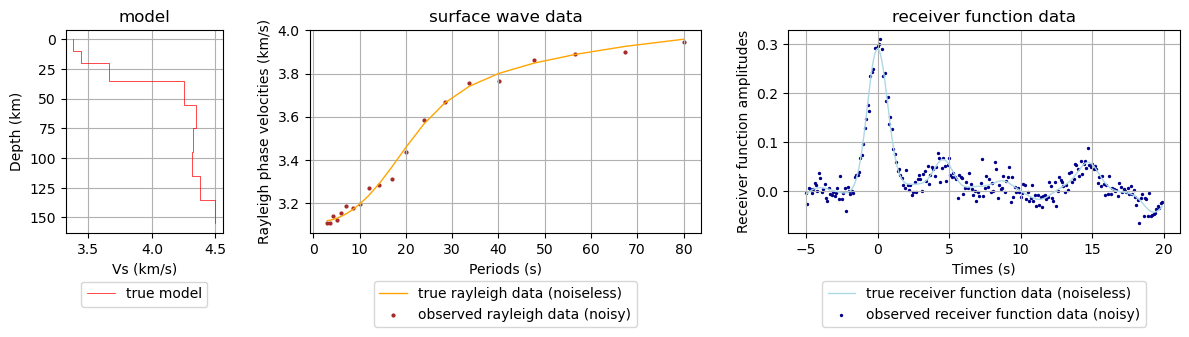

In [21]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 2.5, 2.5]})

# plot true model
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
ax1.grid()

# plot surface wave data
plot_sw_data(rayleigh, periods, ax=ax2, color="orange", label="true rayleigh data (noiseless)")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="brown", s=4, 
          label="observed rayleigh data (noisy)")
ax2.grid()

# plot receiver function data
plot_rf_data(rf, rf_times, ax=ax3, color="lightblue", label="true receiver function data (noiseless)")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="darkblue", s=2, 
          label="observed receiver function data (noisy)")
ax3.grid()

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax3.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))

plt.tight_layout()

## Optimisation

**Prepare `BaseProblem` for optimisation**

In [22]:
n_dims = 17

init_thicknesses = np.ones((n_dims//2,)) * 15
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

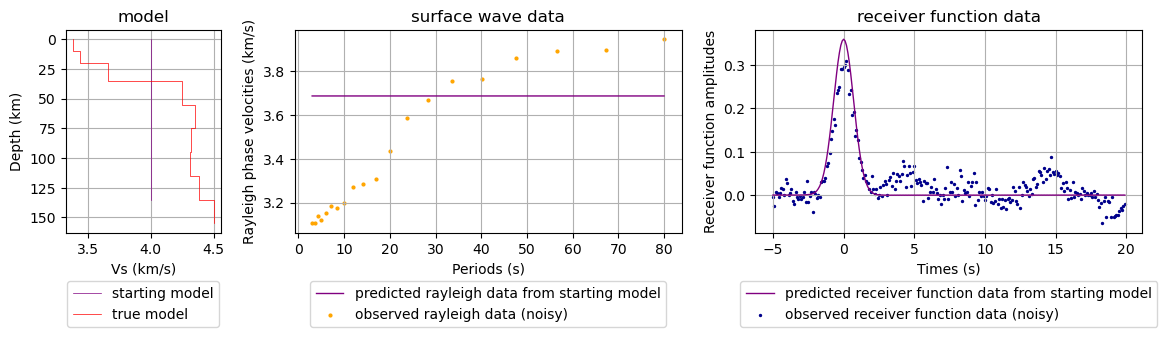

In [23]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 2.5, 2.5]})

# plot true model
plot_model(init_model, ax=ax1, alpha=1, color="purple", label="starting model")
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
ax1.grid()

# plot surface wave data
plot_sw_data(forward_sw(init_model, periods), periods, ax=ax2, color="purple",
             label="predicted rayleigh data from starting model")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="orange", s=4, 
          label="observed rayleigh data (noisy)")
ax2.grid()

# plot receiver function data
plot_rf_data(forward_rf(init_model), rf_times, ax=ax3, color="purple",
             label="predicted receiver function data from starting model")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="darkblue", s=2, 
          label="observed receiver function data (noisy)")
ax3.grid()

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax3.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))

plt.tight_layout()

In [24]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,),
    reference_model=init_model
)

In [25]:
def my_objective(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(model, **fwd_kwargs)
        data_misfit += np.sum((d_obs - d_pred) ** 2)
    reg = my_reg(model)
    return data_misfit + lamda * reg

def my_objective_gradient(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit_grad = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(model, **fwd_kwargs)
        jac = jacobian(model, len(d_obs), fwd, fwd_kwargs)
        data_misfit_grad += -2 * jac.T @ (d_obs - d_pred)
    reg_grad = my_reg.gradient(model)
    return data_misfit_grad + lamda * reg_grad

def my_objective_hessian(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit_hess = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        jac = jacobian(model, len(d_obs), fwd, fwd_kwargs)
        data_misfit_hess += 2 * jac.T @ jac
    reg_hess = my_reg.hessian(model)
    return data_misfit_hess + lamda * reg_hess

In [26]:
fwd_funcs = [
    (forward_sw, {"periods": periods}), 
    (forward_rf, {
        "t_shift": t_shift, 
        "t_duration": t_duration, 
        "t_sampling_interval": t_sampling_interval, 
        "gauss": gauss, 
        "ray_param_s_km": ray_param_s_km
    })
]

d_obs_list = [rayleigh_dobs, rf_dobs]

### Optimisation with no damping

In [27]:
lamda = 0

kwargs = {
    "fwd_funcs": fwd_funcs, 
    "d_obs_list": d_obs_list, 
    "lamda": lamda
}
joint_problem_no_reg = cofi.BaseProblem()
joint_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
joint_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
joint_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
joint_problem_no_reg.set_initial_model(init_model)

**Define `InversionOptions`**

In [28]:
inv_options_optimiser = cofi.InversionOptions()
inv_options_optimiser.set_tool("scipy.optimize.minimize")
inv_options_optimiser.set_params(method="trust-exact")

**Define `Inversion` and run**

In [29]:
inv_optimiser_no_reg = cofi.Inversion(joint_problem_no_reg, inv_options_optimiser)
inv_res_optimiser_no_reg = inv_optimiser_no_reg.run()

**Plot results**

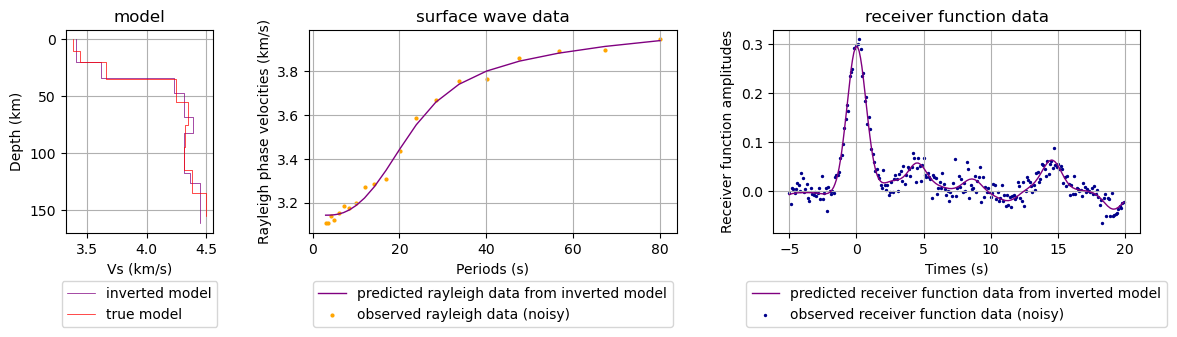

In [30]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 2.5, 2.5]})

# plot true model
plot_model(inv_res_optimiser_no_reg.model, ax=ax1, alpha=1, color="purple", 
           label="inverted model")
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
ax1.grid()

# plot surface wave data
plot_sw_data(forward_sw(inv_res_optimiser_no_reg.model, periods), 
             periods, ax=ax2, color="purple",
             label="predicted rayleigh data from inverted model")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="orange", s=4, 
          label="observed rayleigh data (noisy)")
ax2.grid()

# plot receiver function data
plot_rf_data(forward_rf(inv_res_optimiser_no_reg.model), rf_times, 
             ax=ax3, color="purple",
             label="predicted receiver function data from inverted model")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="darkblue", s=2, 
          label="observed receiver function data (noisy)")
ax3.grid()

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax3.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))

plt.tight_layout()

### Optimal damping

Oh no! The inverted model doesn't look good, and it even has negative thicknesses.

Maybe adding a damping term to our objective function would help... but how can we 
determine a good damping factor?

The `InversionPool` in CoFI can help you answer it.

In [31]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd_funcs": fwd_funcs, 
        "d_obs_list": d_obs_list, 
        "lamda": lamb
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(m, **fwd_kwargs)
        res_norm += np.sum((d_obs - d_pred) ** 2)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 0.07104933167474495, 9.049097273701921


Finished inversion with lambda=7.196856730011514e-06: 0.07109696842718397, 8.409275300318988


Finished inversion with lambda=5.1794746792312125e-05: 0.07160638658554566, 6.164674103931352


Finished inversion with lambda=0.0003727593720314938: 0.0742412823984247, 4.01566194575182


Finished inversion with lambda=0.0026826957952797246: 0.08086773864724396, 3.0830829309412815


Finished inversion with lambda=0.019306977288832496: 0.13848530349997912, 1.5942341865296412


Finished inversion with lambda=0.1389495494373136: 0.1924594326889627, 1.007993536537915


Finished inversion with lambda=1.0: 0.4434917201925289, 0.6558357899856235


Finished inversion with lambda=7.196856730011514: 1.3847229204245646, 0.31168429432535333
Finished inversion with lambda=51.79474679231202: 2.808672845671508, 0.06886180985254571


Finished inversion with lambda=372.7593720314938: 3.245858737550931, 0.010361029438134453


Finished inversion with lambda=2682.6957952797275: 3.3154446809943194, 0.001455626634471428


Finished inversion with lambda=19306.977288832455: 3.325304982660975, 0.00020262004077077224
Finished inversion with lambda=138949.5494373136: 3.326696514681827, 2.8160220793340172e-05
Finished inversion with lambda=1000000.0: 3.3268869187189964, 3.912978902566168e-06


In [32]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

**Plot L-curve**

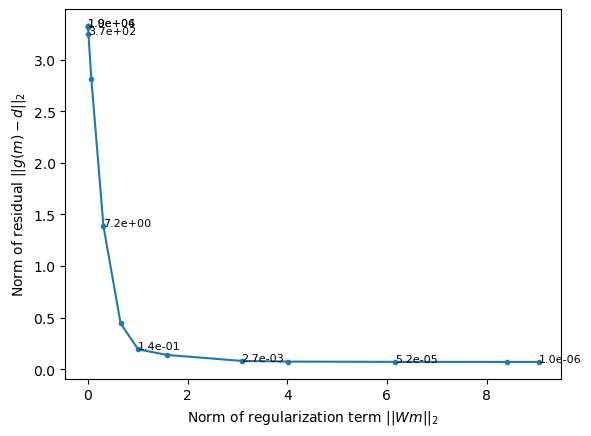

In [33]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

### Optimisation with damping

From the L-curve plot above, it seems that a damping factor of around 0.14
would be good.

In [34]:
lamda = 0.14

kwargs = {
    "fwd_funcs": fwd_funcs, 
    "d_obs_list": d_obs_list, 
    "lamda": lamda
}
joint_problem = cofi.BaseProblem()
joint_problem.set_objective(my_objective, kwargs=kwargs)
joint_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
joint_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
joint_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [35]:
inv_optimiser = cofi.Inversion(joint_problem, inv_options_optimiser)
inv_res_optimiser = inv_optimiser.run()

**Plot results**

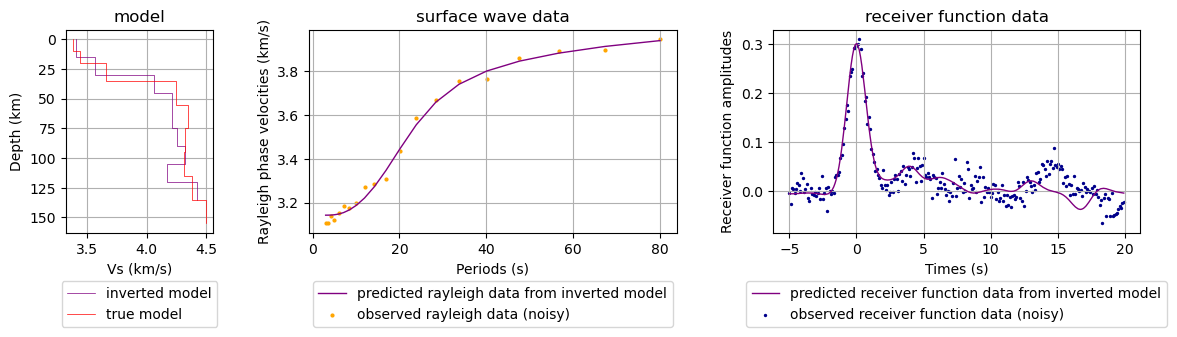

In [36]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 2.5, 2.5]})

# plot true model
plot_model(inv_res_optimiser.model, ax=ax1, alpha=1, color="purple", 
           label="inverted model")
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
ax1.grid()

# plot surface wave data
plot_sw_data(forward_sw(inv_res_optimiser_no_reg.model, periods), 
             periods, ax=ax2, color="purple",
             label="predicted rayleigh data from inverted model")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="orange", s=4, 
          label="observed rayleigh data (noisy)")
ax2.grid()

# plot receiver function data
plot_rf_data(forward_rf(inv_res_optimiser.model), rf_times, 
             ax=ax3, color="purple",
             label="predicted receiver function data from inverted model")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="darkblue", s=2, 
          label="observed receiver function data (noisy)")
ax3.grid()

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
ax3.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))

plt.tight_layout()

## Fixed-dimensional sampling

**Prepare `BaseProblem` for fixed-dimensional sampling**

In [37]:
thick_min = 5
thick_max = 30
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < vs_min) | (vs > vs_max)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = - np.log(thick_max - thick_min) * len(thicknesses) \
                - np.log(vs_max - vs_min) * len(vs)
    return log_prior

In [38]:
# inverse data covariance matrix
Cdinv_rayleigh = np.eye(len(rayleigh_dobs)) / (RAYLEIGH_STD**2)
Cdinv_rf = np.eye(len(rf_dobs)) / (RF_STD**2)
Cdinv_list = [Cdinv_rayleigh, Cdinv_rf]

def my_log_likelihood(
    model, 
    fwd_funcs=fwd_funcs, 
    d_obs_list=d_obs_list, 
    Cdinv_list=Cdinv_list
):
    log_like_sum = 0
    for (fwd, fwd_kwargs), d_obs, Cdinv in zip(fwd_funcs, d_obs_list, Cdinv_list):
        try:
            d_pred = fwd(model, **fwd_kwargs)
        except:
            return float("-inf")
        residual = d_obs - d_pred
        log_like_sum += -0.5 * residual @ (Cdinv @ residual).T
    return log_like_sum

In [39]:
n_walkers = 40

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_res_optimiser.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.5, n_dims)

In [40]:
joint_problem.set_log_prior(my_log_prior)
joint_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [41]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers, 
    nsteps=2_000, 
    initial_state=my_walkers_start, 
    skip_initial_state_check=True, 
    progress=True
)

**Define `Inversion` and run**

### Sample the prior

In [42]:
prior_sampling_problem = cofi.BaseProblem()
prior_sampling_problem.set_log_posterior(my_log_prior)
prior_sampling_problem.set_model_shape(init_model.shape)
prior_sampler = cofi.Inversion(prior_sampling_problem, inv_options_fixed_d_sampling)
prior_results = prior_sampler.run()

  0%|                                                                                                                                                                                                                          | 0/2000 [00:00<?, ?it/s]

  6%|███████████▌                                                                                                                                                                                                  | 112/2000 [00:00<00:01, 1116.05it/s]

 11%|███████████████████████                                                                                                                                                                                       | 224/2000 [00:00<00:01, 1116.83it/s]

 17%|██████████████████████████████████▋                                                                                                                                                                           | 337/2000 [00:00<00:01, 1118.76it/s]

 22%|██████████████████████████████████████████████▎                                                                                                                                                               | 450/2000 [00:00<00:01, 1119.75it/s]

 28%|█████████████████████████████████████████████████████████▉                                                                                                                                                    | 563/2000 [00:00<00:01, 1121.89it/s]

 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 676/2000 [00:00<00:01, 1124.07it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 789/2000 [00:00<00:01, 1118.86it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 903/2000 [00:00<00:00, 1123.07it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1018/2000 [00:00<00:00, 1128.59it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1133/2000 [00:01<00:00, 1133.40it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1249/2000 [00:01<00:00, 1138.98it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1364/2000 [00:01<00:00, 1141.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1480/2000 [00:01<00:00, 1146.04it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1597/2000 [00:01<00:00, 1151.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1714/2000 [00:01<00:00, 1157.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1832/2000 [00:01<00:00, 1161.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1949/2000 [00:01<00:00, 1162.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1140.58it/s]

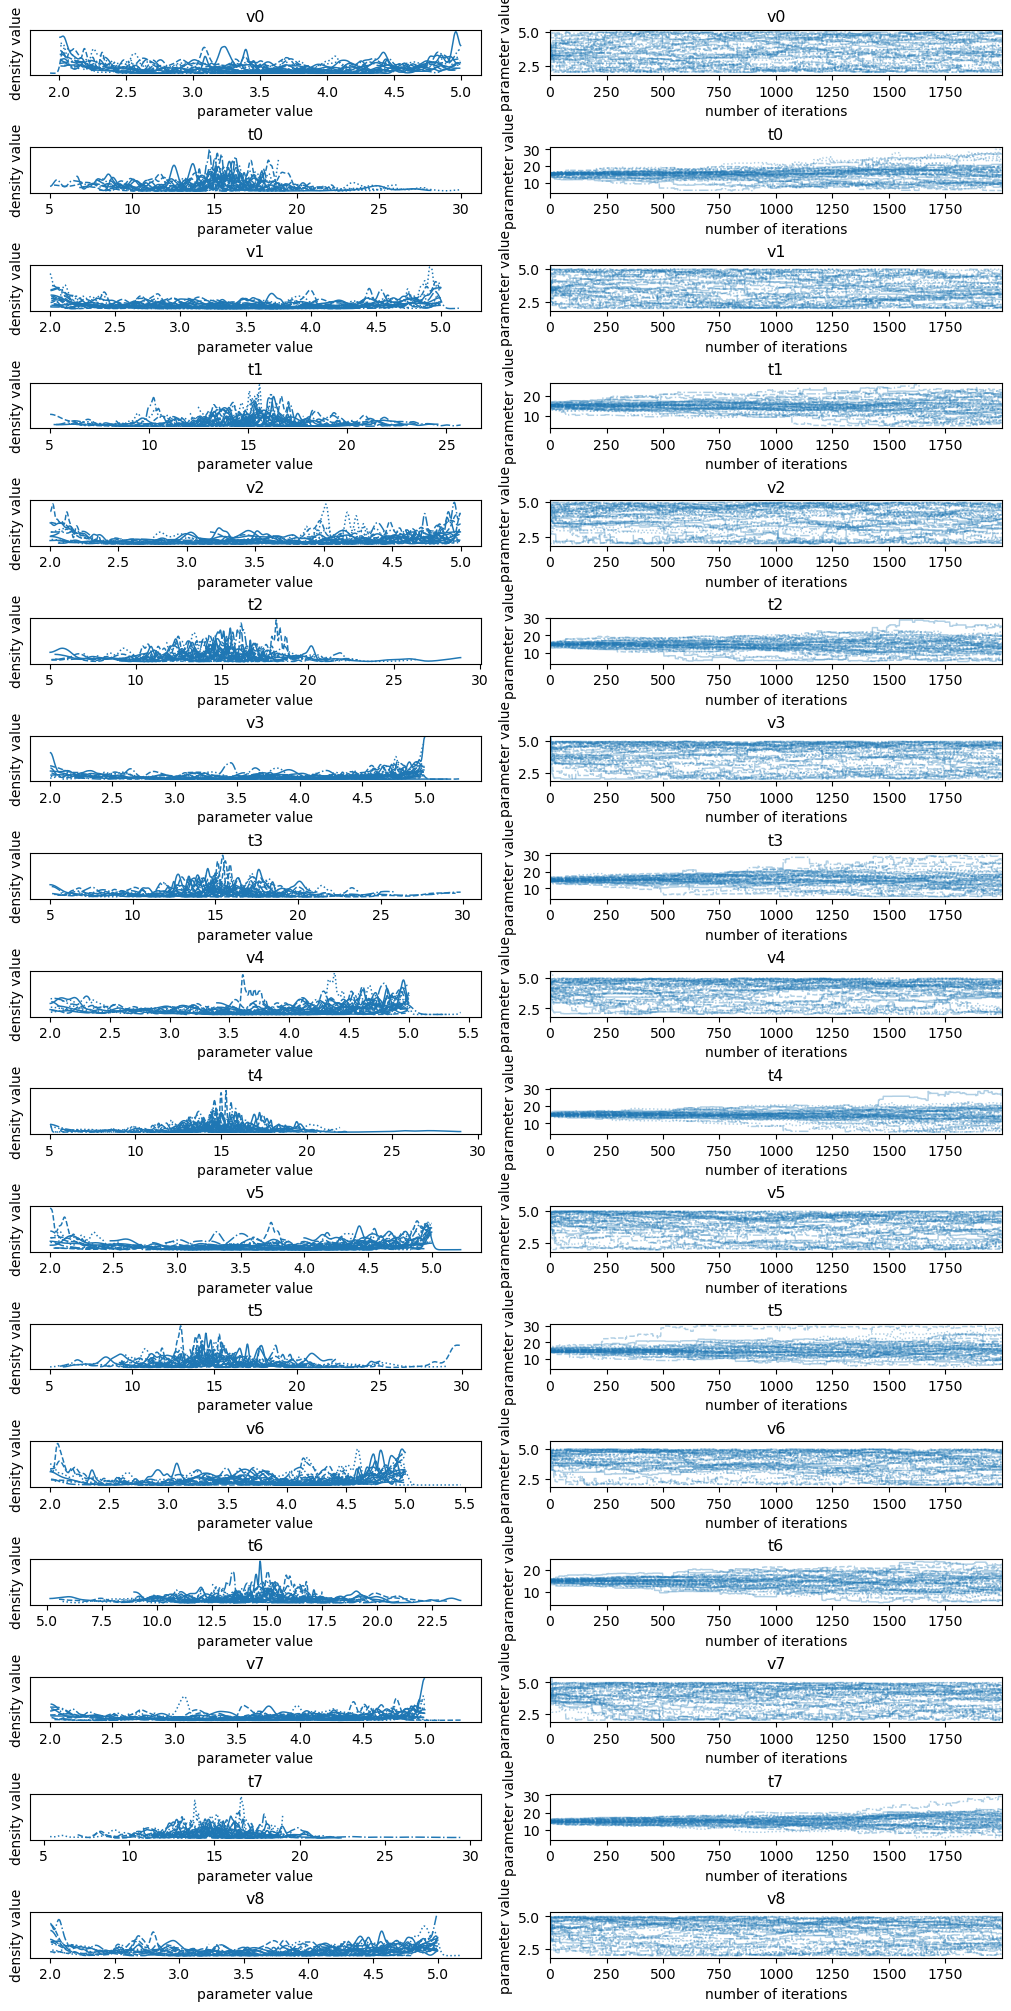

In [43]:
import arviz as az

labels = ["v0", "t0", "v1", "t1", "v2", "t2", "v3", "t3", "v4", "t4", "v5", "t5", "v6", "t6", "v7", "t7", "v8"]

prior_results_sampler = prior_results.sampler
az_idata_prior = az.from_emcee(prior_results_sampler, var_names=labels)

axes = az.plot_trace(
    az_idata_prior, 
    backend_kwargs={"constrained_layout":True}, 
    figsize=(10,20),
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

### Sample the posterior

In [44]:
inversion_fixed_d_sampler = cofi.Inversion(joint_problem, inv_options_fixed_d_sampling)
inv_result_fixed_d_sampler = inversion_fixed_d_sampler.run()

  0%|                                                                                                                                                                                                                          | 0/2000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                 | 2/2000 [00:00<01:43, 19.35it/s]

  0%|▍                                                                                                                                                                                                                 | 4/2000 [00:00<01:48, 18.34it/s]

  0%|▋                                                                                                                                                                                                                 | 6/2000 [00:00<01:51, 17.90it/s]

  0%|▊                                                                                                                                                                                                                 | 8/2000 [00:00<01:58, 16.87it/s]

  0%|█                                                                                                                                                                                                                | 10/2000 [00:00<02:02, 16.22it/s]

  1%|█▎                                                                                                                                                                                                               | 12/2000 [00:00<02:08, 15.44it/s]

  1%|█▍                                                                                                                                                                                                               | 14/2000 [00:00<02:13, 14.84it/s]

  1%|█▋                                                                                                                                                                                                               | 16/2000 [00:01<02:29, 13.24it/s]

  1%|█▉                                                                                                                                                                                                               | 18/2000 [00:01<02:54, 11.33it/s]

  1%|██                                                                                                                                                                                                               | 20/2000 [00:01<02:47, 11.85it/s]

  1%|██▎                                                                                                                                                                                                              | 22/2000 [00:01<02:42, 12.15it/s]

  1%|██▌                                                                                                                                                                                                              | 24/2000 [00:01<02:38, 12.48it/s]

  1%|██▋                                                                                                                                                                                                              | 26/2000 [00:01<02:37, 12.54it/s]

  1%|██▉                                                                                                                                                                                                              | 28/2000 [00:02<02:37, 12.52it/s]

  2%|███▏                                                                                                                                                                                                             | 30/2000 [00:02<02:36, 12.61it/s]

  2%|███▎                                                                                                                                                                                                             | 32/2000 [00:02<02:35, 12.64it/s]

  2%|███▌                                                                                                                                                                                                             | 34/2000 [00:02<02:36, 12.53it/s]

  2%|███▊                                                                                                                                                                                                             | 36/2000 [00:02<02:36, 12.58it/s]

  2%|███▉                                                                                                                                                                                                             | 38/2000 [00:02<02:35, 12.61it/s]

  2%|████▏                                                                                                                                                                                                            | 40/2000 [00:03<02:35, 12.63it/s]

  2%|████▍                                                                                                                                                                                                            | 42/2000 [00:03<02:34, 12.64it/s]

  2%|████▌                                                                                                                                                                                                            | 44/2000 [00:03<02:34, 12.66it/s]

  2%|████▊                                                                                                                                                                                                            | 46/2000 [00:03<02:34, 12.66it/s]

  2%|█████                                                                                                                                                                                                            | 48/2000 [00:03<02:34, 12.66it/s]

  2%|█████▏                                                                                                                                                                                                           | 50/2000 [00:03<02:34, 12.66it/s]

  3%|█████▍                                                                                                                                                                                                           | 52/2000 [00:03<02:34, 12.59it/s]

  3%|█████▋                                                                                                                                                                                                           | 54/2000 [00:04<02:34, 12.59it/s]

  3%|█████▊                                                                                                                                                                                                           | 56/2000 [00:04<02:34, 12.61it/s]

  3%|██████                                                                                                                                                                                                           | 58/2000 [00:04<02:33, 12.64it/s]

  3%|██████▎                                                                                                                                                                                                          | 60/2000 [00:04<02:33, 12.64it/s]

  3%|██████▍                                                                                                                                                                                                          | 62/2000 [00:04<02:33, 12.64it/s]

  3%|██████▋                                                                                                                                                                                                          | 64/2000 [00:04<02:33, 12.65it/s]

  3%|██████▉                                                                                                                                                                                                          | 66/2000 [00:05<02:32, 12.66it/s]

  3%|███████                                                                                                                                                                                                          | 68/2000 [00:05<02:32, 12.65it/s]

  4%|███████▎                                                                                                                                                                                                         | 70/2000 [00:05<02:32, 12.65it/s]

  4%|███████▌                                                                                                                                                                                                         | 72/2000 [00:05<02:32, 12.63it/s]

  4%|███████▋                                                                                                                                                                                                         | 74/2000 [00:05<02:32, 12.62it/s]

  4%|███████▉                                                                                                                                                                                                         | 76/2000 [00:05<02:33, 12.57it/s]

  4%|████████▏                                                                                                                                                                                                        | 78/2000 [00:06<02:32, 12.57it/s]

  4%|████████▎                                                                                                                                                                                                        | 80/2000 [00:06<02:32, 12.60it/s]

  4%|████████▌                                                                                                                                                                                                        | 82/2000 [00:06<02:33, 12.47it/s]

  4%|████████▊                                                                                                                                                                                                        | 84/2000 [00:06<02:32, 12.52it/s]

  4%|████████▉                                                                                                                                                                                                        | 86/2000 [00:06<02:32, 12.54it/s]

  4%|█████████▏                                                                                                                                                                                                       | 88/2000 [00:06<02:32, 12.58it/s]

  4%|█████████▍                                                                                                                                                                                                       | 90/2000 [00:06<02:31, 12.57it/s]

  5%|█████████▌                                                                                                                                                                                                       | 92/2000 [00:07<02:31, 12.59it/s]

  5%|█████████▊                                                                                                                                                                                                       | 94/2000 [00:07<02:31, 12.60it/s]

  5%|██████████                                                                                                                                                                                                       | 96/2000 [00:07<02:31, 12.61it/s]

  5%|██████████▏                                                                                                                                                                                                      | 98/2000 [00:07<02:31, 12.59it/s]

  5%|██████████▍                                                                                                                                                                                                     | 100/2000 [00:07<02:30, 12.61it/s]

  5%|██████████▌                                                                                                                                                                                                     | 102/2000 [00:07<02:30, 12.60it/s]

  5%|██████████▊                                                                                                                                                                                                     | 104/2000 [00:08<02:30, 12.60it/s]

  5%|███████████                                                                                                                                                                                                     | 106/2000 [00:08<02:30, 12.59it/s]

  5%|███████████▏                                                                                                                                                                                                    | 108/2000 [00:08<02:30, 12.60it/s]

  6%|███████████▍                                                                                                                                                                                                    | 110/2000 [00:08<02:30, 12.53it/s]

  6%|███████████▋                                                                                                                                                                                                    | 112/2000 [00:08<02:30, 12.55it/s]

  6%|███████████▊                                                                                                                                                                                                    | 114/2000 [00:08<02:30, 12.55it/s]

  6%|████████████                                                                                                                                                                                                    | 116/2000 [00:09<02:30, 12.55it/s]

  6%|████████████▎                                                                                                                                                                                                   | 118/2000 [00:09<02:29, 12.57it/s]

  6%|████████████▍                                                                                                                                                                                                   | 120/2000 [00:09<02:30, 12.45it/s]

  6%|████████████▋                                                                                                                                                                                                   | 122/2000 [00:09<02:30, 12.50it/s]

  6%|████████████▉                                                                                                                                                                                                   | 124/2000 [00:09<02:29, 12.51it/s]

  6%|█████████████                                                                                                                                                                                                   | 126/2000 [00:09<02:29, 12.55it/s]

  6%|█████████████▎                                                                                                                                                                                                  | 128/2000 [00:10<02:29, 12.55it/s]

  6%|█████████████▌                                                                                                                                                                                                  | 130/2000 [00:10<02:28, 12.58it/s]

  7%|█████████████▋                                                                                                                                                                                                  | 132/2000 [00:10<02:28, 12.58it/s]

  7%|█████████████▉                                                                                                                                                                                                  | 134/2000 [00:10<02:29, 12.49it/s]

  7%|██████████████▏                                                                                                                                                                                                 | 136/2000 [00:10<02:28, 12.52it/s]

  7%|██████████████▎                                                                                                                                                                                                 | 138/2000 [00:10<02:29, 12.45it/s]

  7%|██████████████▌                                                                                                                                                                                                 | 140/2000 [00:10<02:28, 12.49it/s]

  7%|██████████████▊                                                                                                                                                                                                 | 142/2000 [00:11<02:28, 12.51it/s]

  7%|██████████████▉                                                                                                                                                                                                 | 144/2000 [00:11<02:28, 12.53it/s]

  7%|███████████████▏                                                                                                                                                                                                | 146/2000 [00:11<02:27, 12.57it/s]

  7%|███████████████▍                                                                                                                                                                                                | 148/2000 [00:11<02:27, 12.56it/s]

  8%|███████████████▌                                                                                                                                                                                                | 150/2000 [00:11<02:26, 12.59it/s]

  8%|███████████████▊                                                                                                                                                                                                | 152/2000 [00:11<02:26, 12.57it/s]

  8%|████████████████                                                                                                                                                                                                | 154/2000 [00:12<02:27, 12.55it/s]

  8%|████████████████▏                                                                                                                                                                                               | 156/2000 [00:12<02:26, 12.58it/s]

  8%|████████████████▍                                                                                                                                                                                               | 158/2000 [00:12<02:26, 12.57it/s]

  8%|████████████████▋                                                                                                                                                                                               | 160/2000 [00:12<02:26, 12.59it/s]

  8%|████████████████▊                                                                                                                                                                                               | 162/2000 [00:12<02:26, 12.57it/s]

  8%|█████████████████                                                                                                                                                                                               | 164/2000 [00:12<02:26, 12.55it/s]

  8%|█████████████████▎                                                                                                                                                                                              | 166/2000 [00:13<02:34, 11.90it/s]

  8%|█████████████████▍                                                                                                                                                                                              | 168/2000 [00:13<02:31, 12.09it/s]

  8%|█████████████████▋                                                                                                                                                                                              | 170/2000 [00:13<02:29, 12.23it/s]

  9%|█████████████████▉                                                                                                                                                                                              | 172/2000 [00:13<02:28, 12.34it/s]

  9%|██████████████████                                                                                                                                                                                              | 174/2000 [00:13<02:27, 12.39it/s]

  9%|██████████████████▎                                                                                                                                                                                             | 176/2000 [00:13<02:26, 12.45it/s]

  9%|██████████████████▌                                                                                                                                                                                             | 178/2000 [00:14<02:28, 12.24it/s]

  9%|██████████████████▋                                                                                                                                                                                             | 180/2000 [00:14<02:27, 12.34it/s]

  9%|██████████████████▉                                                                                                                                                                                             | 182/2000 [00:14<02:26, 12.41it/s]

  9%|███████████████████▏                                                                                                                                                                                            | 184/2000 [00:14<02:25, 12.44it/s]

  9%|███████████████████▎                                                                                                                                                                                            | 186/2000 [00:14<02:25, 12.49it/s]

  9%|███████████████████▌                                                                                                                                                                                            | 188/2000 [00:14<02:24, 12.50it/s]

 10%|███████████████████▊                                                                                                                                                                                            | 190/2000 [00:14<02:24, 12.53it/s]

 10%|███████████████████▉                                                                                                                                                                                            | 192/2000 [00:15<02:24, 12.52it/s]

 10%|████████████████████▏                                                                                                                                                                                           | 194/2000 [00:15<02:23, 12.54it/s]

 10%|████████████████████▍                                                                                                                                                                                           | 196/2000 [00:15<02:23, 12.53it/s]

 10%|████████████████████▌                                                                                                                                                                                           | 198/2000 [00:15<02:23, 12.54it/s]

 10%|████████████████████▊                                                                                                                                                                                           | 200/2000 [00:15<02:23, 12.53it/s]

 10%|█████████████████████                                                                                                                                                                                           | 202/2000 [00:15<02:23, 12.54it/s]

 10%|█████████████████████▏                                                                                                                                                                                          | 204/2000 [00:16<02:23, 12.53it/s]

 10%|█████████████████████▍                                                                                                                                                                                          | 206/2000 [00:16<02:23, 12.54it/s]

 10%|█████████████████████▋                                                                                                                                                                                          | 208/2000 [00:16<02:22, 12.54it/s]

 10%|█████████████████████▊                                                                                                                                                                                          | 210/2000 [00:16<02:22, 12.54it/s]

 11%|██████████████████████                                                                                                                                                                                          | 212/2000 [00:16<02:22, 12.52it/s]

 11%|██████████████████████▎                                                                                                                                                                                         | 214/2000 [00:16<02:22, 12.53it/s]

 11%|██████████████████████▍                                                                                                                                                                                         | 216/2000 [00:17<02:22, 12.53it/s]

 11%|██████████████████████▋                                                                                                                                                                                         | 218/2000 [00:17<02:22, 12.54it/s]

 11%|██████████████████████▉                                                                                                                                                                                         | 220/2000 [00:17<02:21, 12.54it/s]

 11%|███████████████████████                                                                                                                                                                                         | 222/2000 [00:17<02:22, 12.52it/s]

 11%|███████████████████████▎                                                                                                                                                                                        | 224/2000 [00:17<02:21, 12.54it/s]

 11%|███████████████████████▌                                                                                                                                                                                        | 226/2000 [00:17<02:21, 12.52it/s]

 11%|███████████████████████▋                                                                                                                                                                                        | 228/2000 [00:18<02:21, 12.53it/s]

 12%|███████████████████████▉                                                                                                                                                                                        | 230/2000 [00:18<02:21, 12.51it/s]

 12%|████████████████████████▏                                                                                                                                                                                       | 232/2000 [00:18<02:21, 12.53it/s]

 12%|████████████████████████▎                                                                                                                                                                                       | 234/2000 [00:18<02:22, 12.39it/s]

 12%|████████████████████████▌                                                                                                                                                                                       | 236/2000 [00:18<02:22, 12.41it/s]

 12%|████████████████████████▊                                                                                                                                                                                       | 238/2000 [00:18<02:21, 12.43it/s]

 12%|████████████████████████▉                                                                                                                                                                                       | 240/2000 [00:18<02:21, 12.45it/s]

 12%|█████████████████████████▏                                                                                                                                                                                      | 242/2000 [00:19<02:20, 12.48it/s]

 12%|█████████████████████████▍                                                                                                                                                                                      | 244/2000 [00:19<02:20, 12.48it/s]

 12%|█████████████████████████▌                                                                                                                                                                                      | 246/2000 [00:19<02:20, 12.49it/s]

 12%|█████████████████████████▊                                                                                                                                                                                      | 248/2000 [00:19<02:20, 12.47it/s]

 12%|██████████████████████████                                                                                                                                                                                      | 250/2000 [00:19<02:20, 12.49it/s]

 13%|██████████████████████████▏                                                                                                                                                                                     | 252/2000 [00:19<02:19, 12.50it/s]

 13%|██████████████████████████▍                                                                                                                                                                                     | 254/2000 [00:20<02:19, 12.51it/s]

 13%|██████████████████████████▌                                                                                                                                                                                     | 256/2000 [00:20<02:19, 12.49it/s]

 13%|██████████████████████████▊                                                                                                                                                                                     | 258/2000 [00:20<02:19, 12.50it/s]

 13%|███████████████████████████                                                                                                                                                                                     | 260/2000 [00:20<02:19, 12.51it/s]

 13%|███████████████████████████▏                                                                                                                                                                                    | 262/2000 [00:20<02:19, 12.50it/s]

 13%|███████████████████████████▍                                                                                                                                                                                    | 264/2000 [00:20<02:18, 12.51it/s]

 13%|███████████████████████████▋                                                                                                                                                                                    | 266/2000 [00:21<02:18, 12.52it/s]

 13%|███████████████████████████▊                                                                                                                                                                                    | 268/2000 [00:21<02:18, 12.53it/s]

 14%|████████████████████████████                                                                                                                                                                                    | 270/2000 [00:21<02:18, 12.51it/s]

 14%|████████████████████████████▎                                                                                                                                                                                   | 272/2000 [00:21<02:18, 12.51it/s]

 14%|████████████████████████████▍                                                                                                                                                                                   | 274/2000 [00:21<02:17, 12.52it/s]

 14%|████████████████████████████▋                                                                                                                                                                                   | 276/2000 [00:21<02:17, 12.52it/s]

 14%|████████████████████████████▉                                                                                                                                                                                   | 278/2000 [00:22<02:17, 12.50it/s]

 14%|█████████████████████████████                                                                                                                                                                                   | 280/2000 [00:22<02:17, 12.51it/s]

 14%|█████████████████████████████▎                                                                                                                                                                                  | 282/2000 [00:22<02:17, 12.49it/s]

 14%|█████████████████████████████▌                                                                                                                                                                                  | 284/2000 [00:22<02:17, 12.49it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                  | 286/2000 [00:22<02:17, 12.48it/s]

 14%|█████████████████████████████▉                                                                                                                                                                                  | 288/2000 [00:22<02:16, 12.50it/s]

 14%|██████████████████████████████▏                                                                                                                                                                                 | 290/2000 [00:22<02:17, 12.47it/s]

 15%|██████████████████████████████▎                                                                                                                                                                                 | 292/2000 [00:23<02:16, 12.49it/s]

 15%|██████████████████████████████▌                                                                                                                                                                                 | 294/2000 [00:23<02:16, 12.47it/s]

 15%|██████████████████████████████▊                                                                                                                                                                                 | 296/2000 [00:23<02:16, 12.49it/s]

 15%|██████████████████████████████▉                                                                                                                                                                                 | 298/2000 [00:23<02:16, 12.47it/s]

 15%|███████████████████████████████▏                                                                                                                                                                                | 300/2000 [00:23<02:16, 12.48it/s]

 15%|███████████████████████████████▍                                                                                                                                                                                | 302/2000 [00:23<02:16, 12.47it/s]

 15%|███████████████████████████████▌                                                                                                                                                                                | 304/2000 [00:24<02:15, 12.48it/s]

 15%|███████████████████████████████▊                                                                                                                                                                                | 306/2000 [00:24<02:15, 12.47it/s]

 15%|████████████████████████████████                                                                                                                                                                                | 308/2000 [00:24<02:15, 12.47it/s]

 16%|████████████████████████████████▏                                                                                                                                                                               | 310/2000 [00:24<02:15, 12.46it/s]

 16%|████████████████████████████████▍                                                                                                                                                                               | 312/2000 [00:24<02:15, 12.48it/s]

 16%|████████████████████████████████▋                                                                                                                                                                               | 314/2000 [00:24<02:15, 12.47it/s]

 16%|████████████████████████████████▊                                                                                                                                                                               | 316/2000 [00:25<02:14, 12.48it/s]

 16%|█████████████████████████████████                                                                                                                                                                               | 318/2000 [00:25<02:14, 12.47it/s]

 16%|█████████████████████████████████▎                                                                                                                                                                              | 320/2000 [00:25<02:14, 12.49it/s]

 16%|█████████████████████████████████▍                                                                                                                                                                              | 322/2000 [00:25<02:14, 12.46it/s]

 16%|█████████████████████████████████▋                                                                                                                                                                              | 324/2000 [00:25<02:14, 12.47it/s]

 16%|█████████████████████████████████▉                                                                                                                                                                              | 326/2000 [00:25<02:14, 12.47it/s]

 16%|██████████████████████████████████                                                                                                                                                                              | 328/2000 [00:26<02:13, 12.48it/s]

 16%|██████████████████████████████████▎                                                                                                                                                                             | 330/2000 [00:26<02:13, 12.47it/s]

 17%|██████████████████████████████████▌                                                                                                                                                                             | 332/2000 [00:26<02:13, 12.49it/s]

 17%|██████████████████████████████████▋                                                                                                                                                                             | 334/2000 [00:26<02:13, 12.47it/s]

 17%|██████████████████████████████████▉                                                                                                                                                                             | 336/2000 [00:26<02:13, 12.47it/s]

 17%|███████████████████████████████████▏                                                                                                                                                                            | 338/2000 [00:26<02:13, 12.48it/s]

 17%|███████████████████████████████████▎                                                                                                                                                                            | 340/2000 [00:26<02:13, 12.47it/s]

 17%|███████████████████████████████████▌                                                                                                                                                                            | 342/2000 [00:27<02:12, 12.48it/s]

 17%|███████████████████████████████████▊                                                                                                                                                                            | 344/2000 [00:27<02:12, 12.47it/s]

 17%|███████████████████████████████████▉                                                                                                                                                                            | 346/2000 [00:27<02:12, 12.49it/s]

 17%|████████████████████████████████████▏                                                                                                                                                                           | 348/2000 [00:27<02:12, 12.48it/s]

 18%|████████████████████████████████████▍                                                                                                                                                                           | 350/2000 [00:27<02:12, 12.49it/s]

 18%|████████████████████████████████████▌                                                                                                                                                                           | 352/2000 [00:27<02:11, 12.55it/s]

 18%|████████████████████████████████████▊                                                                                                                                                                           | 354/2000 [00:28<02:11, 12.54it/s]

 18%|█████████████████████████████████████                                                                                                                                                                           | 356/2000 [00:28<02:11, 12.51it/s]

 18%|█████████████████████████████████████▏                                                                                                                                                                          | 358/2000 [00:28<02:11, 12.50it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                          | 360/2000 [00:28<02:11, 12.43it/s]

 18%|█████████████████████████████████████▋                                                                                                                                                                          | 362/2000 [00:28<02:11, 12.48it/s]

 18%|█████████████████████████████████████▊                                                                                                                                                                          | 364/2000 [00:28<02:10, 12.57it/s]

 18%|██████████████████████████████████████                                                                                                                                                                          | 366/2000 [00:29<02:09, 12.57it/s]

 18%|██████████████████████████████████████▎                                                                                                                                                                         | 368/2000 [00:29<02:09, 12.59it/s]

 18%|██████████████████████████████████████▍                                                                                                                                                                         | 370/2000 [00:29<02:08, 12.66it/s]

 19%|██████████████████████████████████████▋                                                                                                                                                                         | 372/2000 [00:29<02:06, 12.84it/s]

 19%|██████████████████████████████████████▉                                                                                                                                                                         | 374/2000 [00:29<02:05, 12.91it/s]

 19%|███████████████████████████████████████                                                                                                                                                                         | 376/2000 [00:29<02:04, 13.03it/s]

 19%|███████████████████████████████████████▎                                                                                                                                                                        | 378/2000 [00:29<02:04, 13.03it/s]

 19%|███████████████████████████████████████▌                                                                                                                                                                        | 380/2000 [00:30<02:19, 11.62it/s]

 19%|███████████████████████████████████████▋                                                                                                                                                                        | 382/2000 [00:30<02:15, 11.92it/s]

 19%|███████████████████████████████████████▉                                                                                                                                                                        | 384/2000 [00:30<02:11, 12.27it/s]

 19%|████████████████████████████████████████▏                                                                                                                                                                       | 386/2000 [00:30<02:08, 12.53it/s]

 19%|████████████████████████████████████████▎                                                                                                                                                                       | 388/2000 [00:30<02:07, 12.65it/s]

 20%|████████████████████████████████████████▌                                                                                                                                                                       | 390/2000 [00:30<02:05, 12.81it/s]

 20%|████████████████████████████████████████▊                                                                                                                                                                       | 392/2000 [00:31<02:04, 12.91it/s]

 20%|████████████████████████████████████████▉                                                                                                                                                                       | 394/2000 [00:31<02:25, 11.06it/s]

 20%|█████████████████████████████████████████▏                                                                                                                                                                      | 396/2000 [00:31<02:16, 11.74it/s]

 20%|█████████████████████████████████████████▍                                                                                                                                                                      | 398/2000 [00:31<02:14, 11.93it/s]

 20%|█████████████████████████████████████████▌                                                                                                                                                                      | 400/2000 [00:31<02:10, 12.25it/s]

 20%|█████████████████████████████████████████▊                                                                                                                                                                      | 402/2000 [00:31<02:07, 12.56it/s]

 20%|██████████████████████████████████████████                                                                                                                                                                      | 404/2000 [00:32<02:03, 12.89it/s]

 20%|██████████████████████████████████████████▏                                                                                                                                                                     | 406/2000 [00:32<02:03, 12.89it/s]

 20%|██████████████████████████████████████████▍                                                                                                                                                                     | 408/2000 [00:32<02:01, 13.10it/s]

 20%|██████████████████████████████████████████▋                                                                                                                                                                     | 410/2000 [00:32<01:57, 13.48it/s]

 21%|██████████████████████████████████████████▊                                                                                                                                                                     | 412/2000 [00:32<01:54, 13.89it/s]

 21%|███████████████████████████████████████████                                                                                                                                                                     | 414/2000 [00:32<01:53, 14.00it/s]

 21%|███████████████████████████████████████████▎                                                                                                                                                                    | 416/2000 [00:32<01:53, 13.99it/s]

 21%|███████████████████████████████████████████▍                                                                                                                                                                    | 418/2000 [00:33<01:54, 13.78it/s]

 21%|███████████████████████████████████████████▋                                                                                                                                                                    | 420/2000 [00:33<01:56, 13.56it/s]

 21%|███████████████████████████████████████████▉                                                                                                                                                                    | 422/2000 [00:33<01:54, 13.77it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                    | 424/2000 [00:33<01:54, 13.78it/s]

 21%|████████████████████████████████████████████▎                                                                                                                                                                   | 426/2000 [00:33<01:52, 13.98it/s]

 21%|████████████████████████████████████████████▌                                                                                                                                                                   | 428/2000 [00:33<01:51, 14.15it/s]

 22%|████████████████████████████████████████████▋                                                                                                                                                                   | 430/2000 [00:33<01:49, 14.30it/s]

 22%|████████████████████████████████████████████▉                                                                                                                                                                   | 432/2000 [00:34<01:49, 14.30it/s]

 22%|█████████████████████████████████████████████▏                                                                                                                                                                  | 434/2000 [00:34<01:48, 14.37it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                                  | 436/2000 [00:34<01:48, 14.39it/s]

 22%|█████████████████████████████████████████████▌                                                                                                                                                                  | 438/2000 [00:34<01:49, 14.27it/s]

 22%|█████████████████████████████████████████████▊                                                                                                                                                                  | 440/2000 [00:34<01:46, 14.66it/s]

 22%|█████████████████████████████████████████████▉                                                                                                                                                                  | 442/2000 [00:34<01:46, 14.58it/s]

 22%|██████████████████████████████████████████████▏                                                                                                                                                                 | 444/2000 [00:34<01:47, 14.46it/s]

 22%|██████████████████████████████████████████████▍                                                                                                                                                                 | 446/2000 [00:35<01:48, 14.26it/s]

 22%|██████████████████████████████████████████████▌                                                                                                                                                                 | 448/2000 [00:35<01:48, 14.26it/s]

 22%|██████████████████████████████████████████████▊                                                                                                                                                                 | 450/2000 [00:35<01:47, 14.47it/s]

 23%|███████████████████████████████████████████████                                                                                                                                                                 | 452/2000 [00:35<01:48, 14.21it/s]

 23%|███████████████████████████████████████████████▏                                                                                                                                                                | 454/2000 [00:35<01:48, 14.20it/s]

 23%|███████████████████████████████████████████████▍                                                                                                                                                                | 456/2000 [00:35<01:47, 14.39it/s]

 23%|███████████████████████████████████████████████▋                                                                                                                                                                | 458/2000 [00:35<01:47, 14.32it/s]

 23%|███████████████████████████████████████████████▊                                                                                                                                                                | 460/2000 [00:36<01:45, 14.64it/s]

 23%|████████████████████████████████████████████████                                                                                                                                                                | 462/2000 [00:36<01:41, 15.09it/s]

 23%|████████████████████████████████████████████████▎                                                                                                                                                               | 464/2000 [00:36<01:40, 15.21it/s]

 23%|████████████████████████████████████████████████▍                                                                                                                                                               | 466/2000 [00:36<01:43, 14.79it/s]

 23%|████████████████████████████████████████████████▋                                                                                                                                                               | 468/2000 [00:36<01:43, 14.75it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                               | 470/2000 [00:36<01:41, 15.05it/s]

 24%|█████████████████████████████████████████████████                                                                                                                                                               | 472/2000 [00:36<01:41, 15.01it/s]

 24%|█████████████████████████████████████████████████▎                                                                                                                                                              | 474/2000 [00:36<01:41, 15.10it/s]

 24%|█████████████████████████████████████████████████▌                                                                                                                                                              | 476/2000 [00:37<01:38, 15.50it/s]

 24%|█████████████████████████████████████████████████▋                                                                                                                                                              | 478/2000 [00:37<01:40, 15.18it/s]

 24%|█████████████████████████████████████████████████▉                                                                                                                                                              | 480/2000 [00:37<01:38, 15.43it/s]

 24%|██████████████████████████████████████████████████▏                                                                                                                                                             | 482/2000 [00:37<01:39, 15.20it/s]

 24%|██████████████████████████████████████████████████▎                                                                                                                                                             | 484/2000 [00:37<01:41, 14.88it/s]

 24%|██████████████████████████████████████████████████▌                                                                                                                                                             | 486/2000 [00:37<01:42, 14.75it/s]

 24%|██████████████████████████████████████████████████▊                                                                                                                                                             | 488/2000 [00:37<01:43, 14.66it/s]

 24%|██████████████████████████████████████████████████▉                                                                                                                                                             | 490/2000 [00:38<01:43, 14.58it/s]

 25%|███████████████████████████████████████████████████▏                                                                                                                                                            | 492/2000 [00:38<01:43, 14.58it/s]

 25%|███████████████████████████████████████████████████▍                                                                                                                                                            | 494/2000 [00:38<01:42, 14.66it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                            | 496/2000 [00:38<01:41, 14.79it/s]

 25%|███████████████████████████████████████████████████▊                                                                                                                                                            | 498/2000 [00:38<01:40, 14.99it/s]

 25%|████████████████████████████████████████████████████                                                                                                                                                            | 500/2000 [00:38<01:42, 14.65it/s]

 25%|████████████████████████████████████████████████████▏                                                                                                                                                           | 502/2000 [00:38<01:41, 14.80it/s]

 25%|████████████████████████████████████████████████████▍                                                                                                                                                           | 504/2000 [00:39<01:41, 14.76it/s]

 25%|████████████████████████████████████████████████████▌                                                                                                                                                           | 506/2000 [00:39<01:40, 14.80it/s]

 25%|████████████████████████████████████████████████████▊                                                                                                                                                           | 508/2000 [00:39<01:40, 14.88it/s]

 26%|█████████████████████████████████████████████████████                                                                                                                                                           | 510/2000 [00:39<01:39, 15.04it/s]

 26%|█████████████████████████████████████████████████████▏                                                                                                                                                          | 512/2000 [00:39<01:39, 14.96it/s]

 26%|█████████████████████████████████████████████████████▍                                                                                                                                                          | 514/2000 [00:39<01:39, 14.87it/s]

 26%|█████████████████████████████████████████████████████▋                                                                                                                                                          | 516/2000 [00:39<01:38, 15.06it/s]

 26%|█████████████████████████████████████████████████████▊                                                                                                                                                          | 518/2000 [00:39<01:38, 15.07it/s]

 26%|██████████████████████████████████████████████████████                                                                                                                                                          | 520/2000 [00:40<01:36, 15.41it/s]

 26%|██████████████████████████████████████████████████████▎                                                                                                                                                         | 522/2000 [00:40<01:35, 15.41it/s]

 26%|██████████████████████████████████████████████████████▍                                                                                                                                                         | 524/2000 [00:40<01:37, 15.21it/s]

 26%|██████████████████████████████████████████████████████▋                                                                                                                                                         | 526/2000 [00:40<01:34, 15.63it/s]

 26%|██████████████████████████████████████████████████████▉                                                                                                                                                         | 528/2000 [00:40<01:33, 15.75it/s]

 26%|███████████████████████████████████████████████████████                                                                                                                                                         | 530/2000 [00:40<01:31, 16.05it/s]

 27%|███████████████████████████████████████████████████████▎                                                                                                                                                        | 532/2000 [00:40<01:31, 16.12it/s]

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                        | 534/2000 [00:40<01:34, 15.59it/s]

 27%|███████████████████████████████████████████████████████▋                                                                                                                                                        | 536/2000 [00:41<01:35, 15.30it/s]

 27%|███████████████████████████████████████████████████████▉                                                                                                                                                        | 538/2000 [00:41<01:36, 15.16it/s]

 27%|████████████████████████████████████████████████████████▏                                                                                                                                                       | 540/2000 [00:41<01:37, 15.05it/s]

 27%|████████████████████████████████████████████████████████▎                                                                                                                                                       | 542/2000 [00:41<01:36, 15.18it/s]

 27%|████████████████████████████████████████████████████████▌                                                                                                                                                       | 544/2000 [00:41<01:36, 15.15it/s]

 27%|████████████████████████████████████████████████████████▊                                                                                                                                                       | 546/2000 [00:41<01:37, 14.84it/s]

 27%|████████████████████████████████████████████████████████▉                                                                                                                                                       | 548/2000 [00:41<01:36, 15.00it/s]

 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                      | 550/2000 [00:42<01:35, 15.22it/s]

 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                      | 552/2000 [00:42<01:32, 15.69it/s]

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                      | 554/2000 [00:42<01:33, 15.47it/s]

 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                      | 556/2000 [00:42<01:33, 15.42it/s]

 28%|██████████████████████████████████████████████████████████                                                                                                                                                      | 558/2000 [00:42<01:30, 15.87it/s]

 28%|██████████████████████████████████████████████████████████▏                                                                                                                                                     | 560/2000 [00:42<01:31, 15.70it/s]

 28%|██████████████████████████████████████████████████████████▍                                                                                                                                                     | 562/2000 [00:42<01:31, 15.65it/s]

 28%|██████████████████████████████████████████████████████████▋                                                                                                                                                     | 564/2000 [00:42<01:31, 15.75it/s]

 28%|██████████████████████████████████████████████████████████▊                                                                                                                                                     | 566/2000 [00:43<01:32, 15.48it/s]

 28%|███████████████████████████████████████████████████████████                                                                                                                                                     | 568/2000 [00:43<01:31, 15.63it/s]

 28%|███████████████████████████████████████████████████████████▎                                                                                                                                                    | 570/2000 [00:43<01:32, 15.53it/s]

 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                    | 572/2000 [00:43<01:31, 15.61it/s]

 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                    | 574/2000 [00:43<01:30, 15.80it/s]

 29%|███████████████████████████████████████████████████████████▉                                                                                                                                                    | 576/2000 [00:43<01:31, 15.65it/s]

 29%|████████████████████████████████████████████████████████████                                                                                                                                                    | 578/2000 [00:43<01:31, 15.48it/s]

 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                   | 580/2000 [00:43<01:30, 15.63it/s]

 29%|████████████████████████████████████████████████████████████▌                                                                                                                                                   | 582/2000 [00:44<01:32, 15.41it/s]

 29%|████████████████████████████████████████████████████████████▋                                                                                                                                                   | 584/2000 [00:44<01:30, 15.62it/s]

 29%|████████████████████████████████████████████████████████████▉                                                                                                                                                   | 586/2000 [00:44<01:30, 15.56it/s]

 29%|█████████████████████████████████████████████████████████████▏                                                                                                                                                  | 588/2000 [00:44<01:27, 16.05it/s]

 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                                  | 590/2000 [00:44<01:25, 16.42it/s]

 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                                  | 592/2000 [00:44<01:26, 16.35it/s]

 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                                  | 594/2000 [00:44<01:25, 16.52it/s]

 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                                  | 596/2000 [00:44<01:26, 16.25it/s]

 30%|██████████████████████████████████████████████████████████████▏                                                                                                                                                 | 598/2000 [00:45<01:27, 15.98it/s]

 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                                 | 600/2000 [00:45<01:30, 15.50it/s]

 30%|██████████████████████████████████████████████████████████████▌                                                                                                                                                 | 602/2000 [00:45<01:29, 15.58it/s]

 30%|██████████████████████████████████████████████████████████████▊                                                                                                                                                 | 604/2000 [00:45<01:32, 15.17it/s]

 30%|███████████████████████████████████████████████████████████████                                                                                                                                                 | 606/2000 [00:45<01:31, 15.29it/s]

 30%|███████████████████████████████████████████████████████████████▏                                                                                                                                                | 608/2000 [00:45<01:31, 15.29it/s]

 30%|███████████████████████████████████████████████████████████████▍                                                                                                                                                | 610/2000 [00:45<01:30, 15.37it/s]

 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                                | 612/2000 [00:45<01:29, 15.57it/s]

 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                                | 614/2000 [00:46<01:29, 15.54it/s]

 31%|████████████████████████████████████████████████████████████████                                                                                                                                                | 616/2000 [00:46<01:27, 15.75it/s]

 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                               | 618/2000 [00:46<01:29, 15.44it/s]

 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                               | 620/2000 [00:46<01:28, 15.54it/s]

 31%|████████████████████████████████████████████████████████████████▋                                                                                                                                               | 622/2000 [00:46<01:27, 15.75it/s]

 31%|████████████████████████████████████████████████████████████████▉                                                                                                                                               | 624/2000 [00:46<01:26, 15.84it/s]

 31%|█████████████████████████████████████████████████████████████████                                                                                                                                               | 626/2000 [00:46<01:24, 16.20it/s]

 31%|█████████████████████████████████████████████████████████████████▎                                                                                                                                              | 628/2000 [00:46<01:25, 16.00it/s]

 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                              | 630/2000 [00:47<01:24, 16.16it/s]

 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                              | 632/2000 [00:47<01:22, 16.49it/s]

 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                              | 634/2000 [00:47<01:23, 16.36it/s]

 32%|██████████████████████████████████████████████████████████████████▏                                                                                                                                             | 636/2000 [00:47<01:24, 16.11it/s]

 32%|██████████████████████████████████████████████████████████████████▎                                                                                                                                             | 638/2000 [00:47<01:21, 16.70it/s]

 32%|██████████████████████████████████████████████████████████████████▌                                                                                                                                             | 640/2000 [00:47<01:24, 16.19it/s]

 32%|██████████████████████████████████████████████████████████████████▊                                                                                                                                             | 642/2000 [00:47<01:23, 16.36it/s]

 32%|██████████████████████████████████████████████████████████████████▉                                                                                                                                             | 644/2000 [00:47<01:23, 16.26it/s]

 32%|███████████████████████████████████████████████████████████████████▏                                                                                                                                            | 646/2000 [00:48<01:23, 16.31it/s]

 32%|███████████████████████████████████████████████████████████████████▍                                                                                                                                            | 648/2000 [00:48<01:21, 16.53it/s]

 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                            | 650/2000 [00:48<01:22, 16.29it/s]

 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                            | 652/2000 [00:48<01:22, 16.36it/s]

 33%|████████████████████████████████████████████████████████████████████                                                                                                                                            | 654/2000 [00:48<01:23, 16.05it/s]

 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 656/2000 [00:48<01:23, 16.03it/s]

 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 658/2000 [00:48<01:24, 15.88it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 660/2000 [00:48<01:21, 16.35it/s]

 33%|████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 662/2000 [00:49<01:21, 16.36it/s]

 33%|█████████████████████████████████████████████████████████████████████                                                                                                                                           | 664/2000 [00:49<01:22, 16.18it/s]

 33%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 666/2000 [00:49<01:22, 16.20it/s]

 33%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 668/2000 [00:49<01:20, 16.45it/s]

 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 670/2000 [00:49<01:19, 16.64it/s]

 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 672/2000 [00:49<01:21, 16.30it/s]

 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                          | 674/2000 [00:49<01:22, 16.13it/s]

 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 676/2000 [00:49<01:21, 16.31it/s]

 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 678/2000 [00:50<01:20, 16.40it/s]

 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 680/2000 [00:50<01:21, 16.10it/s]

 34%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 682/2000 [00:50<01:22, 15.96it/s]

 34%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 684/2000 [00:50<01:24, 15.62it/s]

 34%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 686/2000 [00:50<01:23, 15.69it/s]

 34%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 688/2000 [00:50<01:23, 15.78it/s]

 34%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 690/2000 [00:50<01:22, 15.88it/s]

 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 692/2000 [00:50<01:22, 15.88it/s]

 35%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 694/2000 [00:51<01:20, 16.18it/s]

 35%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 696/2000 [00:51<01:18, 16.64it/s]

 35%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 698/2000 [00:51<01:16, 17.01it/s]

 35%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 700/2000 [00:51<01:15, 17.12it/s]

 35%|█████████████████████████████████████████████████████████████████████████                                                                                                                                       | 702/2000 [00:51<01:17, 16.78it/s]

 35%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 704/2000 [00:51<01:16, 16.87it/s]

 35%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 706/2000 [00:51<01:18, 16.57it/s]

 35%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 708/2000 [00:51<01:16, 16.93it/s]

 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 710/2000 [00:51<01:16, 16.76it/s]

 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                      | 712/2000 [00:52<01:16, 16.73it/s]

 36%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 714/2000 [00:52<01:17, 16.63it/s]

 36%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 716/2000 [00:52<01:20, 16.02it/s]

 36%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 718/2000 [00:52<01:18, 16.37it/s]

 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 720/2000 [00:52<01:17, 16.45it/s]

 36%|███████████████████████████████████████████████████████████████████████████                                                                                                                                     | 722/2000 [00:52<01:17, 16.51it/s]

 36%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 724/2000 [00:52<01:18, 16.26it/s]

 36%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 726/2000 [00:52<01:19, 16.08it/s]

 36%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 728/2000 [00:53<01:20, 15.80it/s]

 36%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 730/2000 [00:53<01:19, 15.96it/s]

 37%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 732/2000 [00:53<01:18, 16.09it/s]

 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 734/2000 [00:53<01:20, 15.67it/s]

 37%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 736/2000 [00:53<01:16, 16.42it/s]

 37%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 738/2000 [00:53<01:18, 16.14it/s]

 37%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 740/2000 [00:53<01:16, 16.48it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 742/2000 [00:53<01:15, 16.57it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 744/2000 [00:54<01:16, 16.37it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 746/2000 [00:54<01:15, 16.57it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 748/2000 [00:54<01:15, 16.60it/s]

 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 750/2000 [00:54<01:15, 16.54it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 752/2000 [00:54<01:17, 16.03it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 754/2000 [00:54<01:16, 16.39it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 756/2000 [00:54<01:17, 16.09it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 758/2000 [00:54<01:17, 16.00it/s]

 38%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 760/2000 [00:55<01:16, 16.25it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 762/2000 [00:55<01:17, 15.99it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 764/2000 [00:55<01:18, 15.82it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 766/2000 [00:55<01:17, 15.92it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 768/2000 [00:55<01:16, 16.07it/s]

 38%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 770/2000 [00:55<01:16, 16.18it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 772/2000 [00:55<01:16, 16.03it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 774/2000 [00:55<01:15, 16.29it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 776/2000 [00:56<01:12, 16.81it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 778/2000 [00:56<01:13, 16.60it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 780/2000 [00:56<01:13, 16.62it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 782/2000 [00:56<01:13, 16.68it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 784/2000 [00:56<01:14, 16.25it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 786/2000 [00:56<01:14, 16.34it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 788/2000 [00:56<01:13, 16.52it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 790/2000 [00:56<01:10, 17.13it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 792/2000 [00:56<01:09, 17.33it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 794/2000 [00:57<01:09, 17.31it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 796/2000 [00:57<01:09, 17.35it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 798/2000 [00:57<01:07, 17.73it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 800/2000 [00:57<01:08, 17.62it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 802/2000 [00:57<01:08, 17.55it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 804/2000 [00:57<01:06, 17.87it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 806/2000 [00:57<01:06, 17.90it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 808/2000 [00:57<01:06, 17.88it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 810/2000 [00:58<01:08, 17.41it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 812/2000 [00:58<01:10, 16.77it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 814/2000 [00:58<01:10, 16.74it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 816/2000 [00:58<01:12, 16.44it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 818/2000 [00:58<01:12, 16.23it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 820/2000 [00:58<01:10, 16.68it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 822/2000 [00:58<01:09, 16.93it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 824/2000 [00:58<01:08, 17.10it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 826/2000 [00:58<01:07, 17.48it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 828/2000 [00:59<01:07, 17.31it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 830/2000 [00:59<01:10, 16.70it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 832/2000 [00:59<01:09, 16.81it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 834/2000 [00:59<01:09, 16.78it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 836/2000 [00:59<01:09, 16.70it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 838/2000 [00:59<01:09, 16.61it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 840/2000 [00:59<01:10, 16.39it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 842/2000 [00:59<01:09, 16.71it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 844/2000 [01:00<01:09, 16.55it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 847/2000 [01:00<01:04, 17.89it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 849/2000 [01:00<01:18, 14.70it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 851/2000 [01:00<01:14, 15.41it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 853/2000 [01:00<01:13, 15.70it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 855/2000 [01:00<01:08, 16.67it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 857/2000 [01:00<01:06, 17.10it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 859/2000 [01:00<01:07, 16.81it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 861/2000 [01:01<01:07, 16.92it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 863/2000 [01:01<01:07, 16.83it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 865/2000 [01:01<01:07, 16.73it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 867/2000 [01:01<01:22, 13.65it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 869/2000 [01:01<01:18, 14.39it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 871/2000 [01:01<01:15, 15.00it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 873/2000 [01:01<01:12, 15.46it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 875/2000 [01:02<01:10, 16.03it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 877/2000 [01:02<01:06, 16.77it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 879/2000 [01:02<01:06, 16.90it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 881/2000 [01:02<01:05, 17.21it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 883/2000 [01:02<01:06, 16.91it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 885/2000 [01:02<01:05, 17.13it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 887/2000 [01:02<01:04, 17.14it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 890/2000 [01:02<01:03, 17.35it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 892/2000 [01:02<01:03, 17.43it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 894/2000 [01:03<01:03, 17.37it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 896/2000 [01:03<01:04, 17.00it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 898/2000 [01:03<01:03, 17.28it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 900/2000 [01:03<01:03, 17.22it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 902/2000 [01:03<01:01, 17.78it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 904/2000 [01:03<01:03, 17.23it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 906/2000 [01:03<01:03, 17.24it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 908/2000 [01:03<01:05, 16.63it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 910/2000 [01:04<01:04, 16.92it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 912/2000 [01:04<01:03, 17.23it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 914/2000 [01:04<01:04, 16.84it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 916/2000 [01:04<01:05, 16.55it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 918/2000 [01:04<01:03, 17.00it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 920/2000 [01:04<01:03, 16.90it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 922/2000 [01:04<01:04, 16.83it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 924/2000 [01:04<01:02, 17.20it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 926/2000 [01:04<01:02, 17.12it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 928/2000 [01:05<01:02, 17.23it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 930/2000 [01:05<01:02, 17.21it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 932/2000 [01:05<01:01, 17.34it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 934/2000 [01:05<00:59, 17.96it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 936/2000 [01:05<00:58, 18.25it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 938/2000 [01:05<00:58, 18.13it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 940/2000 [01:05<01:00, 17.67it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 942/2000 [01:05<01:00, 17.61it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 944/2000 [01:05<00:58, 18.13it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 946/2000 [01:06<00:59, 17.76it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 948/2000 [01:06<01:00, 17.51it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 950/2000 [01:06<00:59, 17.55it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 953/2000 [01:06<00:57, 18.25it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 955/2000 [01:06<00:58, 17.93it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 957/2000 [01:06<00:58, 17.77it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 959/2000 [01:06<00:58, 17.65it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 961/2000 [01:06<01:01, 16.91it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 963/2000 [01:07<00:59, 17.45it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 965/2000 [01:07<00:59, 17.25it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 967/2000 [01:07<00:59, 17.28it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 969/2000 [01:07<01:01, 16.79it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 971/2000 [01:07<01:00, 16.91it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 973/2000 [01:07<00:59, 17.12it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 975/2000 [01:07<00:59, 17.19it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 977/2000 [01:07<01:00, 16.88it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 979/2000 [01:08<01:00, 17.01it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 981/2000 [01:08<00:59, 17.19it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 983/2000 [01:08<00:56, 17.85it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 985/2000 [01:08<00:59, 17.18it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 987/2000 [01:08<00:59, 16.93it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 989/2000 [01:08<01:00, 16.74it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 991/2000 [01:08<00:58, 17.30it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 993/2000 [01:08<00:58, 17.12it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 995/2000 [01:08<00:58, 17.30it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 997/2000 [01:09<01:00, 16.70it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 999/2000 [01:09<00:59, 16.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1001/2000 [01:09<00:57, 17.30it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1004/2000 [01:09<00:54, 18.25it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 1006/2000 [01:09<00:54, 18.35it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1008/2000 [01:09<00:57, 17.39it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1010/2000 [01:09<00:56, 17.54it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1012/2000 [01:09<00:57, 17.33it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1014/2000 [01:10<00:55, 17.68it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1016/2000 [01:10<00:55, 17.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1018/2000 [01:10<00:53, 18.21it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1020/2000 [01:10<00:55, 17.51it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1023/2000 [01:10<00:53, 18.41it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1025/2000 [01:10<00:54, 18.02it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1027/2000 [01:10<00:53, 18.05it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1029/2000 [01:10<00:53, 17.99it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1031/2000 [01:10<00:53, 18.21it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1033/2000 [01:11<00:53, 18.01it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1035/2000 [01:11<00:53, 18.12it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1037/2000 [01:11<00:53, 17.95it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1039/2000 [01:11<00:52, 18.33it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1041/2000 [01:11<00:51, 18.52it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1043/2000 [01:11<00:51, 18.46it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1045/2000 [01:11<00:50, 18.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1047/2000 [01:11<00:52, 18.07it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1049/2000 [01:11<00:52, 18.02it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1051/2000 [01:12<00:53, 17.90it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1053/2000 [01:12<00:52, 18.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1055/2000 [01:12<00:51, 18.51it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1057/2000 [01:12<00:51, 18.24it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1060/2000 [01:12<00:49, 19.08it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1062/2000 [01:12<00:49, 19.12it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1064/2000 [01:12<00:49, 18.97it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1066/2000 [01:12<00:50, 18.38it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1068/2000 [01:12<00:51, 18.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2000 [01:13<00:50, 18.48it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1073/2000 [01:13<00:49, 18.59it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1076/2000 [01:13<00:48, 19.14it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1078/2000 [01:13<00:48, 18.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1081/2000 [01:13<00:47, 19.18it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1083/2000 [01:13<00:47, 19.25it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1085/2000 [01:13<00:49, 18.67it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1087/2000 [01:13<00:48, 18.80it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1089/2000 [01:14<00:49, 18.52it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1092/2000 [01:14<00:48, 18.74it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1094/2000 [01:14<00:48, 18.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1096/2000 [01:14<00:48, 18.56it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1098/2000 [01:14<00:47, 18.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1101/2000 [01:14<00:46, 19.36it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1103/2000 [01:14<00:46, 19.21it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1105/2000 [01:14<00:47, 19.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1107/2000 [01:15<00:47, 18.65it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1109/2000 [01:15<00:47, 18.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1111/2000 [01:15<00:47, 18.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1113/2000 [01:15<00:47, 18.55it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1115/2000 [01:15<00:47, 18.58it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1118/2000 [01:15<00:47, 18.73it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1120/2000 [01:15<00:47, 18.47it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1122/2000 [01:15<00:47, 18.32it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1124/2000 [01:15<00:48, 18.01it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1126/2000 [01:16<00:47, 18.27it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1129/2000 [01:16<00:45, 19.06it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1131/2000 [01:16<00:47, 18.47it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1133/2000 [01:16<00:47, 18.23it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1135/2000 [01:16<00:48, 17.96it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1138/2000 [01:16<00:47, 18.27it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1140/2000 [01:16<00:47, 18.26it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1142/2000 [01:16<00:47, 17.99it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1144/2000 [01:17<00:46, 18.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1147/2000 [01:17<00:45, 18.84it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1149/2000 [01:17<00:45, 18.60it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1151/2000 [01:17<00:47, 18.06it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1153/2000 [01:17<00:46, 18.07it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1155/2000 [01:17<00:46, 18.28it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1157/2000 [01:17<00:47, 17.60it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1159/2000 [01:17<00:48, 17.27it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1161/2000 [01:18<00:48, 17.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1163/2000 [01:18<00:47, 17.46it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1165/2000 [01:18<00:48, 17.17it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1167/2000 [01:18<00:48, 17.23it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1169/2000 [01:18<00:47, 17.37it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1171/2000 [01:18<00:46, 17.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1174/2000 [01:18<00:45, 18.32it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1176/2000 [01:18<00:44, 18.31it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1178/2000 [01:18<00:44, 18.39it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1181/2000 [01:19<00:43, 18.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1183/2000 [01:19<00:43, 18.61it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1186/2000 [01:19<00:41, 19.79it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1188/2000 [01:19<00:42, 19.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1190/2000 [01:19<00:42, 19.10it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1192/2000 [01:19<00:41, 19.26it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1195/2000 [01:19<00:40, 19.99it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1198/2000 [01:19<00:39, 20.44it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1201/2000 [01:20<00:40, 19.69it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1203/2000 [01:20<00:40, 19.72it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1206/2000 [01:20<00:40, 19.56it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1208/2000 [01:20<00:41, 19.14it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1210/2000 [01:20<00:41, 18.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1213/2000 [01:20<00:41, 19.12it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1215/2000 [01:20<00:41, 19.07it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1217/2000 [01:20<00:43, 18.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1219/2000 [01:21<00:44, 17.51it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1222/2000 [01:21<00:42, 18.43it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1224/2000 [01:21<00:41, 18.58it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1227/2000 [01:21<00:40, 18.98it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1229/2000 [01:21<00:41, 18.50it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1232/2000 [01:21<00:40, 18.76it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1234/2000 [01:21<00:40, 19.04it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1236/2000 [01:21<00:40, 18.70it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1238/2000 [01:22<00:41, 18.22it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1240/2000 [01:22<00:41, 18.15it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1242/2000 [01:22<00:41, 18.19it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1244/2000 [01:22<00:41, 18.39it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1246/2000 [01:22<00:40, 18.56it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1249/2000 [01:22<00:38, 19.54it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1251/2000 [01:22<00:39, 19.08it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1253/2000 [01:22<00:41, 18.13it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1255/2000 [01:23<00:40, 18.34it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1257/2000 [01:23<00:40, 18.14it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1259/2000 [01:23<00:41, 17.91it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1261/2000 [01:23<00:42, 17.46it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1263/2000 [01:23<00:41, 17.92it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1266/2000 [01:23<00:39, 18.71it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1269/2000 [01:23<00:38, 18.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1272/2000 [01:23<00:38, 18.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1274/2000 [01:24<00:39, 18.36it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1276/2000 [01:24<00:38, 18.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1279/2000 [01:24<00:37, 19.11it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1281/2000 [01:24<00:37, 19.30it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1283/2000 [01:24<00:37, 19.32it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1285/2000 [01:24<00:37, 19.11it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1287/2000 [01:24<00:37, 18.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1289/2000 [01:24<00:37, 19.07it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1291/2000 [01:24<00:37, 18.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1293/2000 [01:25<00:37, 19.02it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1295/2000 [01:25<00:38, 18.21it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1297/2000 [01:25<00:38, 18.13it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1300/2000 [01:25<00:38, 18.30it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1302/2000 [01:25<00:38, 18.04it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1304/2000 [01:25<00:38, 18.10it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1307/2000 [01:25<00:37, 18.50it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1309/2000 [01:25<00:38, 17.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1311/2000 [01:26<00:38, 17.76it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1313/2000 [01:26<00:38, 17.96it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1315/2000 [01:26<00:38, 17.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1317/2000 [01:26<00:37, 18.22it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1319/2000 [01:26<00:37, 17.92it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1321/2000 [01:26<00:38, 17.71it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1323/2000 [01:26<00:39, 17.22it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1325/2000 [01:26<00:38, 17.57it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1327/2000 [01:26<00:38, 17.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1329/2000 [01:27<00:38, 17.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1331/2000 [01:27<00:39, 17.01it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1334/2000 [01:27<00:37, 17.69it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1336/2000 [01:27<00:37, 17.57it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1338/2000 [01:27<00:37, 17.47it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1340/2000 [01:27<00:38, 17.31it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1342/2000 [01:27<00:37, 17.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1344/2000 [01:27<00:36, 17.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1346/2000 [01:28<00:36, 17.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1348/2000 [01:28<00:37, 17.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1350/2000 [01:28<00:36, 17.95it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1353/2000 [01:28<00:35, 18.48it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1355/2000 [01:28<00:34, 18.66it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1357/2000 [01:28<00:34, 18.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1359/2000 [01:28<00:36, 17.66it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1361/2000 [01:28<00:36, 17.37it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1363/2000 [01:29<00:36, 17.31it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1365/2000 [01:29<00:35, 17.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1368/2000 [01:29<00:33, 18.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1370/2000 [01:29<00:34, 18.42it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1372/2000 [01:29<00:35, 17.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1374/2000 [01:29<00:34, 17.97it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1376/2000 [01:29<00:35, 17.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1378/2000 [01:29<00:35, 17.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1380/2000 [01:29<00:34, 17.98it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1382/2000 [01:30<00:34, 17.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1384/2000 [01:30<00:34, 17.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1387/2000 [01:30<00:33, 18.41it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1389/2000 [01:30<00:33, 18.45it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1391/2000 [01:30<00:40, 14.99it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1394/2000 [01:30<00:37, 16.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1396/2000 [01:30<00:35, 16.98it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1398/2000 [01:30<00:34, 17.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1401/2000 [01:31<00:32, 18.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1403/2000 [01:31<00:33, 17.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1405/2000 [01:31<00:34, 17.49it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1407/2000 [01:31<00:33, 17.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1409/2000 [01:31<00:33, 17.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1411/2000 [01:31<00:43, 13.61it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1413/2000 [01:31<00:39, 14.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1415/2000 [01:32<00:36, 15.94it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1417/2000 [01:32<00:35, 16.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1419/2000 [01:32<00:33, 17.32it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1421/2000 [01:32<00:33, 17.51it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1424/2000 [01:32<00:31, 18.30it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1426/2000 [01:32<00:31, 18.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1428/2000 [01:32<00:31, 18.23it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1430/2000 [01:32<00:30, 18.51it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1432/2000 [01:32<00:31, 18.31it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1435/2000 [01:33<00:29, 19.02it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1437/2000 [01:33<00:30, 18.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1440/2000 [01:33<00:28, 19.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1442/2000 [01:33<00:29, 19.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1444/2000 [01:33<00:30, 18.40it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1446/2000 [01:33<00:30, 18.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1448/2000 [01:33<00:29, 18.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1450/2000 [01:33<00:30, 18.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1452/2000 [01:34<00:30, 18.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1454/2000 [01:34<00:29, 18.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1456/2000 [01:34<00:29, 18.65it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1458/2000 [01:34<00:28, 18.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1460/2000 [01:34<00:29, 18.52it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1463/2000 [01:34<00:27, 19.30it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1465/2000 [01:34<00:27, 19.45it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1467/2000 [01:34<00:28, 18.97it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1470/2000 [01:34<00:26, 19.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1473/2000 [01:35<00:26, 19.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1475/2000 [01:35<00:26, 19.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1477/2000 [01:35<00:26, 19.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1479/2000 [01:35<00:26, 19.63it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1481/2000 [01:35<00:27, 18.92it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1483/2000 [01:35<00:26, 19.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1485/2000 [01:35<00:27, 18.69it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1487/2000 [01:35<00:27, 18.45it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1489/2000 [01:35<00:27, 18.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1491/2000 [01:36<00:27, 18.33it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1493/2000 [01:36<00:27, 18.33it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1495/2000 [01:36<00:27, 18.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1497/2000 [01:36<00:26, 18.77it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1500/2000 [01:36<00:26, 18.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1503/2000 [01:36<00:26, 18.76it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1505/2000 [01:36<00:26, 18.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1507/2000 [01:36<00:27, 18.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1509/2000 [01:37<00:26, 18.38it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1512/2000 [01:37<00:26, 18.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1514/2000 [01:37<00:25, 18.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1516/2000 [01:37<00:26, 18.30it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1518/2000 [01:37<00:26, 18.35it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1520/2000 [01:37<00:26, 18.37it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1522/2000 [01:37<00:25, 18.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1524/2000 [01:37<00:25, 18.32it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1527/2000 [01:38<00:25, 18.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1529/2000 [01:38<00:25, 18.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1532/2000 [01:38<00:24, 19.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1534/2000 [01:38<00:24, 19.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1536/2000 [01:38<00:24, 19.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1538/2000 [01:38<00:25, 18.24it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1540/2000 [01:38<00:24, 18.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1542/2000 [01:38<00:25, 18.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1544/2000 [01:38<00:25, 17.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1546/2000 [01:39<00:25, 18.04it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1548/2000 [01:39<00:25, 17.45it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1551/2000 [01:39<00:24, 18.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1553/2000 [01:39<00:24, 17.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1556/2000 [01:39<00:23, 18.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1558/2000 [01:39<00:23, 18.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1560/2000 [01:39<00:24, 18.33it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1562/2000 [01:39<00:23, 18.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1564/2000 [01:40<00:23, 18.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1566/2000 [01:40<00:23, 18.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1568/2000 [01:40<00:23, 18.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1571/2000 [01:40<00:22, 19.23it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1573/2000 [01:40<00:22, 19.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1575/2000 [01:40<00:22, 18.93it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1577/2000 [01:40<00:22, 19.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1579/2000 [01:40<00:23, 18.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1581/2000 [01:40<00:26, 15.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1583/2000 [01:41<00:24, 16.70it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1585/2000 [01:41<00:24, 16.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1587/2000 [01:41<00:23, 17.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1589/2000 [01:41<00:23, 17.32it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1591/2000 [01:41<00:23, 17.69it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1593/2000 [01:41<00:23, 17.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1595/2000 [01:41<00:23, 17.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1597/2000 [01:41<00:22, 17.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1599/2000 [01:42<00:22, 17.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1601/2000 [01:42<00:23, 17.28it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1603/2000 [01:42<00:22, 17.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1605/2000 [01:42<00:21, 18.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1607/2000 [01:42<00:21, 18.22it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1609/2000 [01:42<00:21, 18.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1611/2000 [01:42<00:21, 18.35it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1613/2000 [01:42<00:21, 17.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1615/2000 [01:42<00:21, 17.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1617/2000 [01:43<00:21, 17.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1620/2000 [01:43<00:20, 18.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1622/2000 [01:43<00:20, 18.70it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1624/2000 [01:43<00:20, 18.27it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1626/2000 [01:43<00:20, 18.15it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1628/2000 [01:43<00:20, 18.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1630/2000 [01:43<00:20, 18.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1632/2000 [01:43<00:19, 18.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1634/2000 [01:43<00:19, 18.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1636/2000 [01:44<00:19, 18.58it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1638/2000 [01:44<00:19, 18.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1641/2000 [01:44<00:18, 19.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1644/2000 [01:44<00:16, 21.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1647/2000 [01:44<00:17, 19.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1650/2000 [01:44<00:18, 19.40it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1652/2000 [01:44<00:18, 19.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1654/2000 [01:44<00:17, 19.30it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1656/2000 [01:45<00:18, 19.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1658/2000 [01:45<00:17, 19.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1661/2000 [01:45<00:17, 19.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1664/2000 [01:45<00:16, 20.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1667/2000 [01:45<00:16, 20.59it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1670/2000 [01:45<00:16, 20.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1673/2000 [01:45<00:16, 20.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1676/2000 [01:46<00:16, 19.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1678/2000 [01:46<00:16, 19.37it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1680/2000 [01:46<00:17, 18.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1682/2000 [01:46<00:17, 18.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1684/2000 [01:46<00:17, 18.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1687/2000 [01:46<00:16, 18.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1690/2000 [01:46<00:15, 19.45it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1692/2000 [01:46<00:16, 18.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1694/2000 [01:47<00:16, 18.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1696/2000 [01:47<00:15, 19.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1698/2000 [01:47<00:16, 18.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1700/2000 [01:47<00:15, 18.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1703/2000 [01:47<00:15, 19.36it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1705/2000 [01:47<00:15, 18.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1707/2000 [01:47<00:15, 19.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1709/2000 [01:47<00:15, 19.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1712/2000 [01:47<00:14, 19.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1714/2000 [01:48<00:14, 19.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1716/2000 [01:48<00:15, 18.41it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1718/2000 [01:48<00:15, 18.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1721/2000 [01:48<00:14, 19.61it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1723/2000 [01:48<00:14, 19.62it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1725/2000 [01:48<00:13, 19.70it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1728/2000 [01:48<00:13, 19.71it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1731/2000 [01:48<00:13, 20.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1734/2000 [01:49<00:13, 20.29it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1737/2000 [01:49<00:13, 19.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1740/2000 [01:49<00:13, 19.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1742/2000 [01:49<00:13, 19.38it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1745/2000 [01:49<00:12, 19.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1748/2000 [01:49<00:12, 19.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1750/2000 [01:49<00:13, 19.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1752/2000 [01:50<00:13, 18.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1754/2000 [01:50<00:13, 18.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1756/2000 [01:50<00:13, 18.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1759/2000 [01:50<00:12, 18.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1761/2000 [01:50<00:12, 18.79it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1763/2000 [01:50<00:13, 18.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1766/2000 [01:50<00:12, 19.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1768/2000 [01:50<00:12, 19.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1771/2000 [01:50<00:11, 19.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1773/2000 [01:51<00:11, 19.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1775/2000 [01:51<00:11, 19.08it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1777/2000 [01:51<00:11, 19.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1780/2000 [01:51<00:10, 20.03it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1782/2000 [01:51<00:11, 19.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1785/2000 [01:51<00:11, 19.43it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1787/2000 [01:51<00:11, 19.35it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1789/2000 [01:51<00:10, 19.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1791/2000 [01:52<00:11, 18.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1793/2000 [01:52<00:10, 19.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1796/2000 [01:52<00:10, 19.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1799/2000 [01:52<00:09, 20.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1802/2000 [01:52<00:10, 19.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1804/2000 [01:52<00:10, 19.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1806/2000 [01:52<00:10, 19.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1808/2000 [01:52<00:10, 18.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1810/2000 [01:53<00:10, 18.96it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1812/2000 [01:53<00:10, 18.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1815/2000 [01:53<00:09, 19.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1817/2000 [01:53<00:09, 19.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1819/2000 [01:53<00:09, 19.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1822/2000 [01:53<00:09, 19.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1824/2000 [01:53<00:09, 19.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1827/2000 [01:53<00:08, 19.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1830/2000 [01:54<00:08, 19.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1833/2000 [01:54<00:08, 19.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1836/2000 [01:54<00:08, 19.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1838/2000 [01:54<00:08, 19.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1840/2000 [01:54<00:08, 19.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1843/2000 [01:54<00:07, 20.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1846/2000 [01:54<00:07, 19.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1849/2000 [01:55<00:07, 20.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1852/2000 [01:55<00:07, 19.68it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1855/2000 [01:55<00:07, 20.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1858/2000 [01:55<00:06, 20.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1861/2000 [01:55<00:06, 19.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1864/2000 [01:55<00:06, 19.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1866/2000 [01:55<00:06, 19.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1869/2000 [01:56<00:06, 19.35it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1872/2000 [01:56<00:06, 19.64it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1874/2000 [01:56<00:06, 19.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1876/2000 [01:56<00:06, 19.39it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1879/2000 [01:56<00:06, 19.94it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1881/2000 [01:56<00:06, 19.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1884/2000 [01:56<00:05, 20.66it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1887/2000 [01:56<00:05, 20.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1890/2000 [01:57<00:05, 20.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1893/2000 [01:57<00:05, 20.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1896/2000 [01:57<00:05, 20.61it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1899/2000 [01:57<00:05, 20.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1902/2000 [01:57<00:04, 19.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1905/2000 [01:57<00:04, 19.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1908/2000 [01:57<00:04, 19.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1910/2000 [01:58<00:04, 19.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1912/2000 [01:58<00:04, 18.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1915/2000 [01:58<00:04, 18.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1917/2000 [01:58<00:04, 18.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1919/2000 [01:58<00:04, 18.72it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1921/2000 [01:58<00:04, 18.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1923/2000 [01:58<00:04, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1926/2000 [01:58<00:03, 19.07it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1929/2000 [01:59<00:03, 19.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1931/2000 [01:59<00:03, 19.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1933/2000 [01:59<00:03, 19.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1935/2000 [01:59<00:03, 19.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1938/2000 [01:59<00:03, 19.61it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1941/2000 [01:59<00:02, 20.27it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1944/2000 [01:59<00:02, 20.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1947/2000 [01:59<00:02, 20.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1950/2000 [02:00<00:02, 19.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1953/2000 [02:00<00:02, 19.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1955/2000 [02:00<00:02, 19.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1957/2000 [02:00<00:02, 19.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1959/2000 [02:00<00:02, 19.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1961/2000 [02:00<00:02, 16.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1963/2000 [02:00<00:02, 16.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1965/2000 [02:01<00:02, 17.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1967/2000 [02:01<00:01, 17.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1969/2000 [02:01<00:01, 17.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1972/2000 [02:01<00:01, 18.89it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1975/2000 [02:01<00:01, 20.16it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1978/2000 [02:01<00:01, 20.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1981/2000 [02:01<00:00, 19.67it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1983/2000 [02:02<00:01, 16.18it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1985/2000 [02:02<00:00, 16.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1987/2000 [02:02<00:00, 17.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1989/2000 [02:02<00:00, 17.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1992/2000 [02:02<00:00, 17.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1994/2000 [02:02<00:00, 18.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1996/2000 [02:02<00:00, 18.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [02:02<00:00, 18.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.27it/s]

In [45]:
sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [46]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables: (12/17)
    v0       (chain, draw) float64 3.366 3.261 3.311 3.311 ... 3.409 3.409 3.409
    t0       (chain, draw) float64 13.77 13.93 14.24 14.24 ... 20.26 20.26 20.26
    v1       (chain, draw) float64 4.01 3.839 3.713 3.713 ... 3.624 3.624 3.624
    t1       (chain, draw) float64 16.51 16.25 15.82 15.82 ... 14.28 14.28 14.28
    v2       (chain, draw) float64 4.24 4.145 4.301 4.301 ... 4.185 4.185 4.185
    t2       (chain, draw) float64 14.73 14.71 14.9 14.9 ... 8.927 8.927 8.927
    ...       ...
    t5       (chain, draw) float64 14.38 14.57 14.66 14.66 ... 17.71 17.71 17.71
    v6       (chain, draw) float64 4.655 4.65 4.831 4.831 ... 4.283 4.283 4.283
    t6       (chain, draw) float64 15.11 15.12 14.98 14.98 ... 10.24 10.24 10.24
    v7       (chain, draw) float64 3.949 3.954 4.21 4.21 ... 4.278 4.278 4.278
    t7       (chain, draw) float64 14.8 14.86 15.0 15.0 ... 17.89 17.89 17.89
    v8       (chain, draw) float64 4.854 4.803 4.762 4.762 ... 4.437 4.437 4.437
Attributes:
    created_at:                 2024-04-16T23:40:19.068740
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

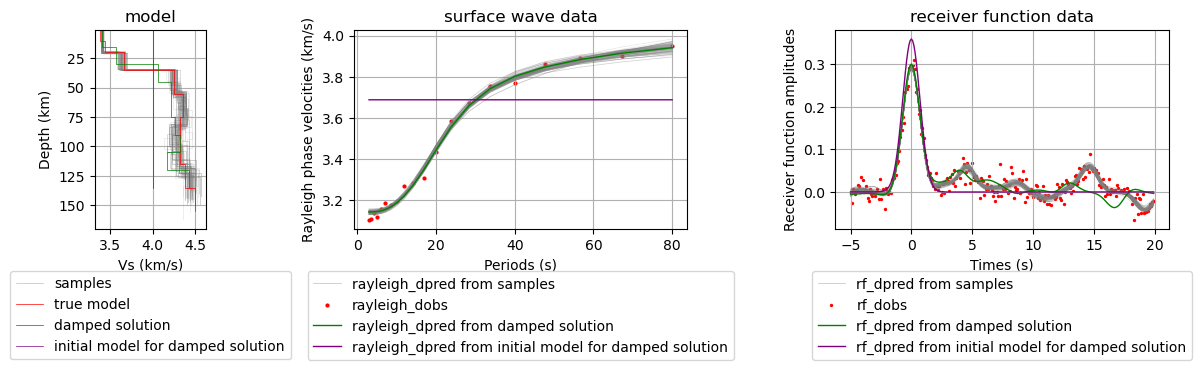

In [47]:
flat_samples = sampler.get_chain(discard=500, thin=500, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 3, 3]})

ax1.set_ylim(170)

# plot samples and data predictions from samples
for idx in rand_indices:
    sample = flat_samples[idx]
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_sw_data(forward_sw(sample, periods), periods, 
                 ax=ax2, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf(sample), rf_times,
                 ax=ax3, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
sample_0 = flat_samples[rand_indices[0]]
plot_model(sample_0, ax=ax1, alpha=0.5, lw=0.5, color="gray", label="samples")
plot_sw_data(forward_sw(sample_0, periods), periods, ax=ax2, 
             alpha=0.5, lw=0.5, color="gray", label="rayleigh_dpred from samples")
plot_rf_data(forward_rf(sample_0), rf_times, ax=ax3, 
             alpha=0.5, lw=0.5, color="gray", label="rf_dpred from samples")

# plot true model and data observations
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="r", s=2, 
          label="rf_dobs")

# plot damped optimisation result
plot_model(inv_res_optimiser.model, ax=ax1, alpha=1, color="green", 
           label="damped solution")
plot_sw_data(forward_sw(inv_res_optimiser_no_reg.model, periods), 
             periods, ax=ax2, color="green",
             label="rayleigh_dpred from damped solution")
plot_rf_data(forward_rf(inv_res_optimiser.model), rf_times, 
             ax=ax3, color="green",
             label="rf_dpred from damped solution")

# plot initial model for dampied optimsiation
plot_model(init_model, ax=ax1, alpha=1, color="purple", 
           label="initial model for damped solution")
plot_sw_data(forward_sw(init_model, periods), periods, ax=ax2, color="purple",
             label="rayleigh_dpred from initial model for damped solution")
plot_rf_data(forward_rf(init_model), rf_times, ax=ax3, color="purple",
             label="rf_dpred from initial model for damped solution")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax3.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax1.grid()
ax2.grid()
ax3.grid()

plt.tight_layout()

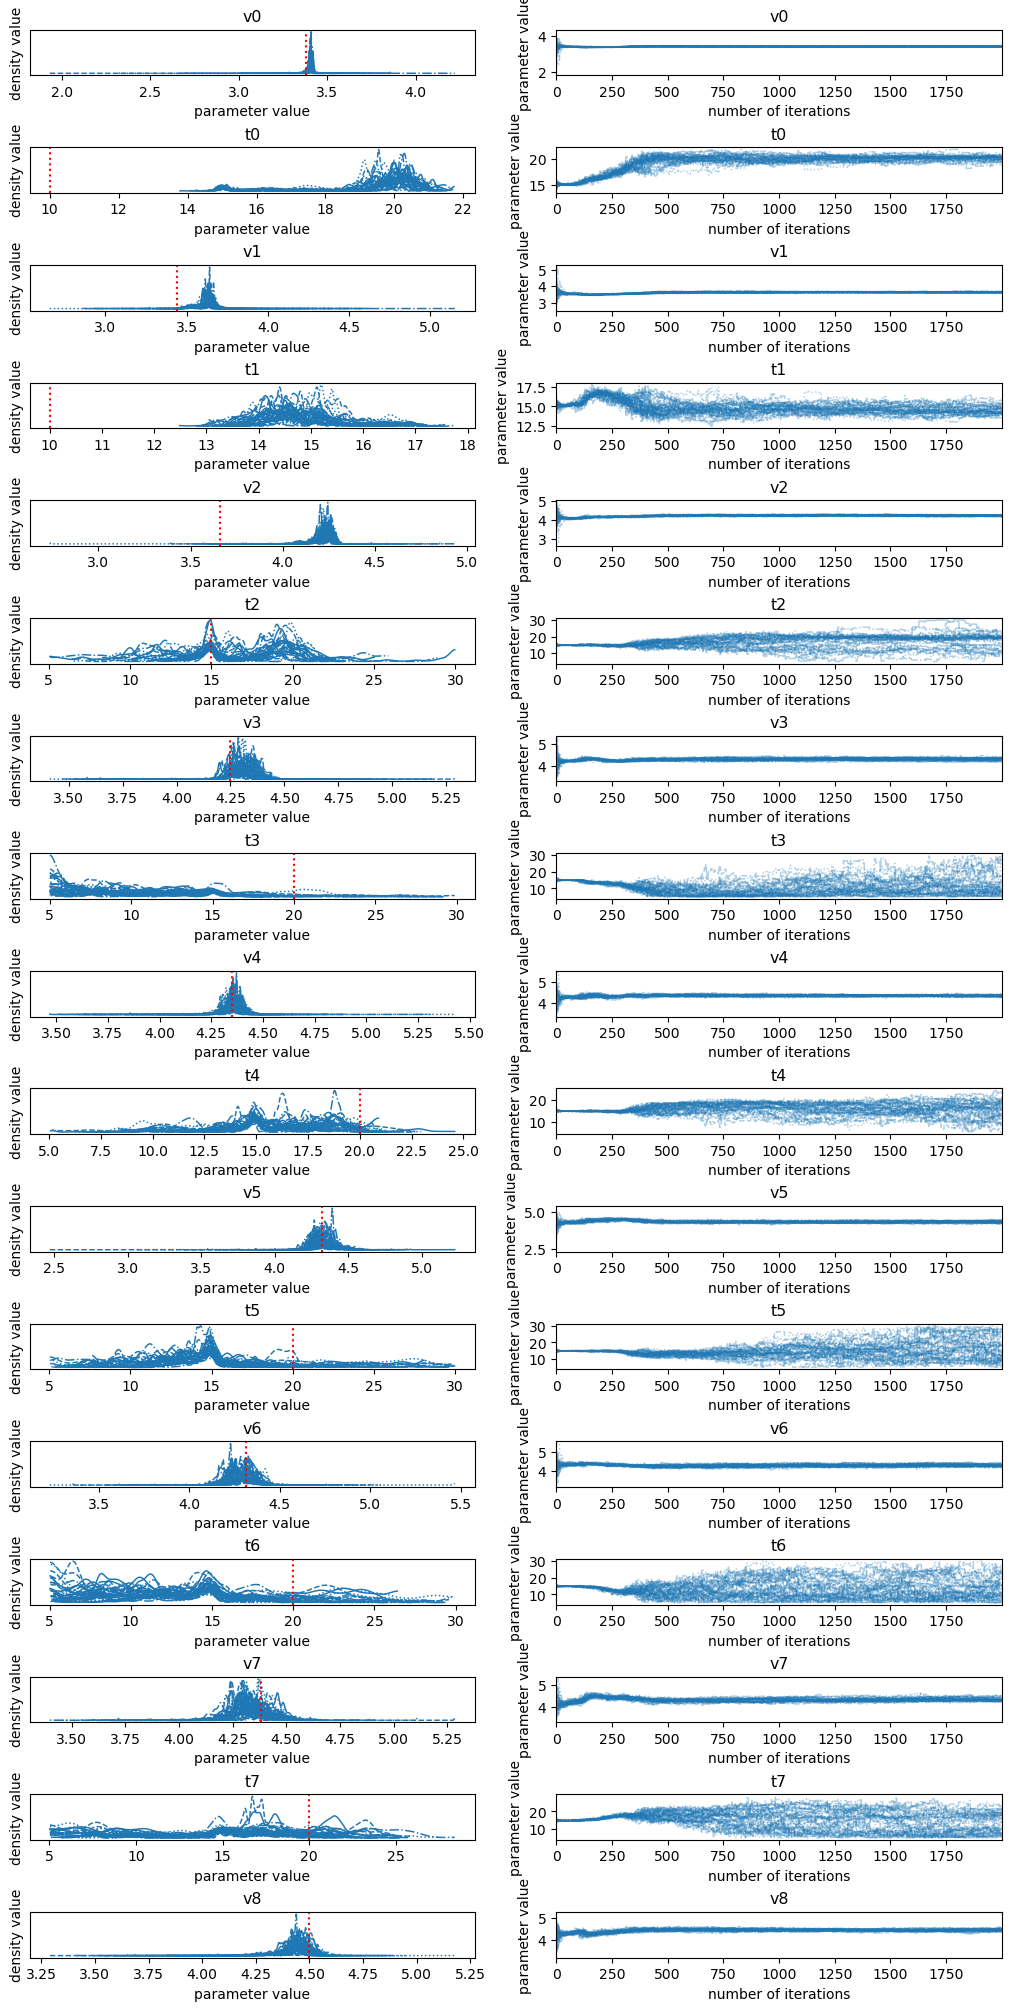

In [48]:
axes = az.plot_trace(
    az_idata, 
    backend_kwargs={"constrained_layout":True},
    figsize=(10,20)
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

## Trans-dimensional sampling

**Prepare utilities for trans-d sampling**

In [49]:
def fwd_rayleigh_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw(model, periods)

def fwd_rf_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_rf(model)

In [50]:
targets = [
    bayesbay.Target("rayleigh", rayleigh_dobs, covariance_mat_inv=1 / RAYLEIGH_STD**2),
    bayesbay.Target("rf", rf_dobs, covariance_mat_inv=1 / RF_STD**2),
]
forward_funcs = [fwd_rayleigh_for_bayesbay, fwd_rf_for_bayesbay]

my_log_likelihood = bayesbay.LogLikelihood(targets, forward_funcs)

In [51]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [52]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=15, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [53]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [54]:
inv_options_trans_d = cofi.InversionOptions()
inv_options_trans_d.set_tool("bayesbay")
inv_options_trans_d.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=2_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [55]:
inversion_trans_d_sampler = cofi.Inversion(joint_problem, inv_options_trans_d)
inv_res_trans_d_sampler = inversion_trans_d_sampler.run()

In [56]:
saved_states = inv_res_trans_d_sampler.models
samples_voronoi = saved_states["voronoi.discretization"]
samples_vs = saved_states["voronoi.vs"]
interp_depths = np.arange(150, dtype=float)

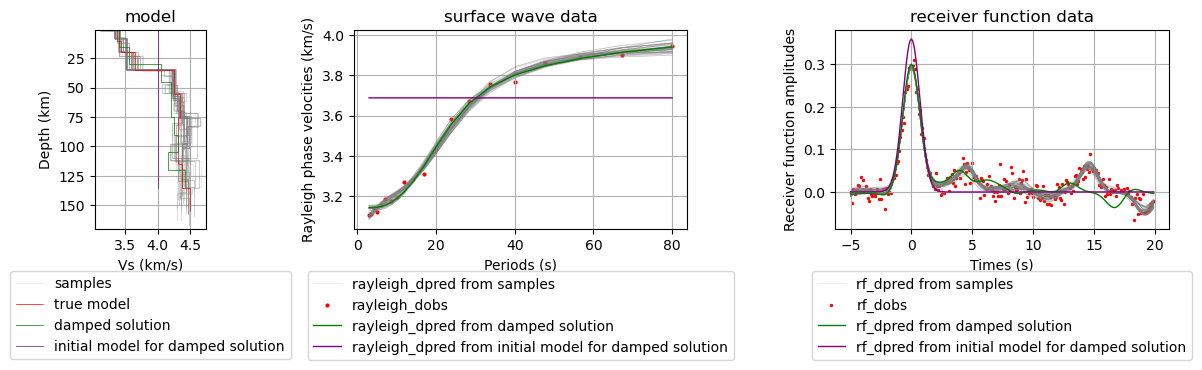

In [57]:
rand_indices = np.random.randint(len(samples_voronoi), size=100)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 3, 3]})

ax1.set_ylim(170)

# plot samples and data predictions from samples
for idx in rand_indices:
    sample_voronoi = form_voronoi_model(samples_voronoi[idx], samples_vs[idx])
    sample = voronoi_to_layercake(sample_voronoi)
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_sw_data(forward_sw(sample, periods), periods, 
                 ax=ax2, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf(sample), rf_times,
                 ax=ax3, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
sample_0_voronoi = form_voronoi_model(samples_voronoi[0], samples_vs[0])
sample_0 = voronoi_to_layercake(sample_0_voronoi)
plot_model(sample_0, ax=ax1, alpha=0.2, lw=0.5, color="gray", label="samples")
plot_sw_data(forward_sw(sample_0, periods), periods, ax=ax2, 
             alpha=0.2, lw=0.5, color="gray", label="rayleigh_dpred from samples")
plot_rf_data(forward_rf(sample_0), rf_times, ax=ax3, 
             alpha=0.2, lw=0.5, color="gray", label="rf_dpred from samples")

# plot true model and data observations
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
plot_sw_data(rayleigh_dobs, periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")
plot_rf_data(rf_dobs, rf_times, ax=ax3, scatter=True, color="r", s=2, 
          label="rf_dobs")

# plot damped optimisation result
plot_model(inv_res_optimiser.model, ax=ax1, alpha=1, color="green", 
           label="damped solution")
plot_sw_data(forward_sw(inv_res_optimiser_no_reg.model, periods), 
             periods, ax=ax2, color="green",
             label="rayleigh_dpred from damped solution")
plot_rf_data(forward_rf(inv_res_optimiser.model), rf_times, 
             ax=ax3, color="green",
             label="rf_dpred from damped solution")

# plot initial model for dampied optimsiation
plot_model(init_model, ax=ax1, alpha=1, color="purple", 
           label="initial model for damped solution")
plot_sw_data(forward_sw(init_model, periods), periods, ax=ax2, color="purple",
             label="rayleigh_dpred from initial model for damped solution")
plot_rf_data(forward_rf(init_model), rf_times, ax=ax3, color="purple",
             label="rf_dpred from initial model for damped solution")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax3.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax1.grid()
ax2.grid()
ax3.grid()

plt.tight_layout()

----
## Watermark

In [58]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "scipy", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
espresso 0.3.13
numpy 1.23.5
matplotlib 3.7.1
scipy 1.10.1
bayesbay 0.3.0
